# 데이터 수집

[캐글의 Football Data from Transfermarkt](https://www.kaggle.com/datasets/davidcariboo/player-scores) 데이터 이용

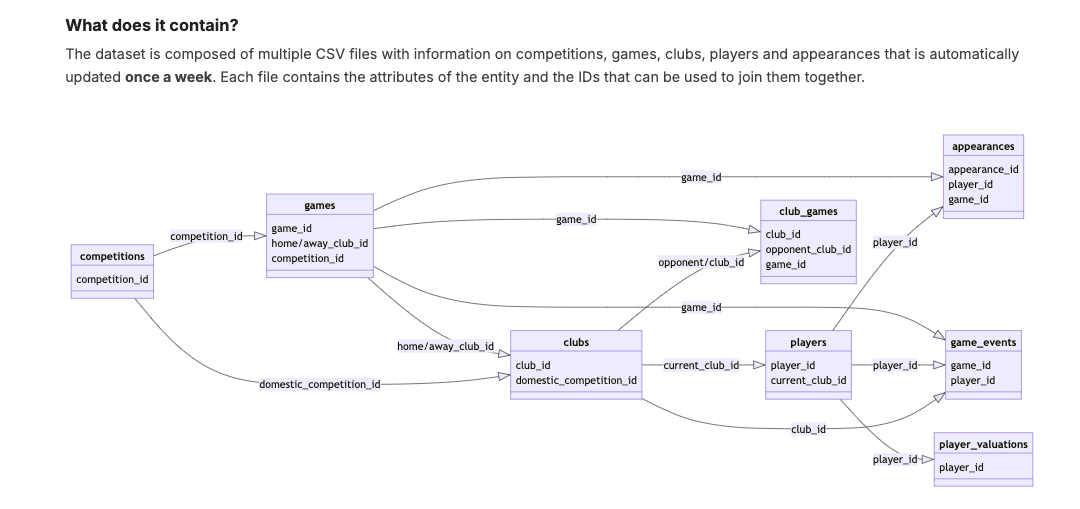

# Import Libraries

In [633]:
# !pip install geopy
# !pip install plotly
# !pip install selenium

In [634]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import time
import plotly.express as px
import folium
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
import re

# Functions

## count_value(df, column)

In [241]:
def count_value(df, column):
    count = len(df[column].unique())
    print(f'Total {column}: {count}')

# Import Data

In [242]:
players_path = './data/archive/players.csv'
players_valuations_path = './data/archive/player_valuations.csv'

players = pd.read_csv(players_path)
players_valuations = pd.read_csv(players_valuations_path)

In [243]:
clubs_path = './data/archive/clubs.csv'
competitions_path = './data/archive/competitions.csv'

clubs = pd.read_csv(clubs_path)
competitions = pd.read_csv(competitions_path)

# 데이터셋 살펴보기

## info()

In [244]:
print(players.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32421 entries, 0 to 32420
Data columns (total 23 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   player_id                             32421 non-null  int64  
 1   first_name                            30361 non-null  object 
 2   last_name                             32421 non-null  object 
 3   name                                  32421 non-null  object 
 4   last_season                           32421 non-null  int64  
 5   current_club_id                       32421 non-null  int64  
 6   player_code                           32421 non-null  object 
 7   country_of_birth                      29635 non-null  object 
 8   city_of_birth                         29975 non-null  object 
 9   country_of_citizenship                32041 non-null  object 
 10  date_of_birth                         32374 non-null  object 
 11  sub_position   

null 값이 존재하는 컬럼들이 꽤 있는 거 같음

In [245]:
print(players_valuations.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490450 entries, 0 to 490449
Data columns (total 5 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   player_id                            490450 non-null  int64 
 1   date                                 490450 non-null  object
 2   market_value_in_eur                  490450 non-null  int64 
 3   current_club_id                      490450 non-null  int64 
 4   player_club_domestic_competition_id  490450 non-null  object
dtypes: int64(3), object(2)
memory usage: 18.7+ MB
None


null 값이 없는 듯<br>
근데, 선수 정보 대비 몸값 정보가 더 많다.

In [246]:
display(players.head())
display(players_valuations.head())

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,...,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
0,10,Miroslav,Klose,Miroslav Klose,2015,398,miroslav-klose,Poland,Opole,Germany,...,right,184.000,NaN,ASBW Sport Marketing,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/miroslav-klose...,IT1,Società Sportiva Lazio S.p.A.,1000000.000,30000000.000
1,26,Roman,Weidenfeller,Roman Weidenfeller,2017,16,roman-weidenfeller,Germany,Diez,Germany,...,left,190.000,NaN,Neubauer 13 GmbH,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/roman-weidenfe...,L1,Borussia Dortmund,750000.000,8000000.000
2,65,Dimitar,Berbatov,Dimitar Berbatov,2015,1091,dimitar-berbatov,Bulgaria,Blagoevgrad,Bulgaria,...,NaN,NaN,NaN,CSKA-AS-23 Ltd.,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/dimitar-berbat...,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000.000,34500000.000
3,77,NaN,Lúcio,Lúcio,2012,506,lucio,Brazil,Brasília,Brazil,...,NaN,NaN,NaN,NaN,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lucio/profil/s...,IT1,Juventus Football Club,200000.000,24500000.000
4,80,Tom,Starke,Tom Starke,2017,27,tom-starke,East Germany (GDR),Freital,Germany,...,right,194.000,NaN,IFM,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/tom-starke/pro...,L1,FC Bayern München,100000.000,3000000.000


,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id
0,405973,2000-01-20,150000,3057,BE1
1,342216,2001-07-20,100000,1241,SC1
2,3132,2003-12-09,400000,126,TR1
3,6893,2003-12-15,900000,984,GB1
4,10,2004-10-04,7000000,398,IT1


축구가 주류인 곳이 유럽이기 때문에 몸값 단위가 유로로 되어있음

## columns 확인

In [247]:
print(players.columns)
print(players_valuations.columns)

Index(['player_id', 'first_name', 'last_name', 'name', 'last_season',
       'current_club_id', 'player_code', 'country_of_birth', 'city_of_birth',
       'country_of_citizenship', 'date_of_birth', 'sub_position', 'position',
       'foot', 'height_in_cm', 'contract_expiration_date', 'agent_name',
       'image_url', 'url', 'current_club_domestic_competition_id',
       'current_club_name', 'market_value_in_eur',
       'highest_market_value_in_eur'],
      dtype='object')
Index(['player_id', 'date', 'market_value_in_eur', 'current_club_id',
       'player_club_domestic_competition_id'],
      dtype='object')


### players 정보에서 원하는 컬럼들만 선택

In [248]:
columns = ['player_id', 'first_name', 'last_name', 'name', 'last_season', 'current_club_id', 'player_code', 'country_of_birth', 'city_of_birth', 'country_of_citizenship', 'date_of_birth', 'sub_position', 'position']
players = players[columns]

## 결측치 확인

In [249]:
print(players.isna().sum(), '\n')
print(players_valuations.isna().sum(), '\n')

player_id                    0
first_name                2060
last_name                    0
name                         0
last_season                  0
current_club_id              0
player_code                  0
country_of_birth          2786
city_of_birth             2446
country_of_citizenship     380
date_of_birth               47
sub_position               183
position                     0
dtype: int64 

player_id                              0
date                                   0
market_value_in_eur                    0
current_club_id                        0
player_club_domestic_competition_id    0
dtype: int64 



In [250]:
players[players['date_of_birth'].isna()]

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position
14,299,Fabian,Ernst,Fabian Ernst,2012,10484,fabian-ernst,Germany,Hannover,Germany,NaN,Defensive Midfield,Midfield
35,837,Thorben,Marx,Thorben Marx,2014,18,thorben-marx,Germany,Berlin,Germany,NaN,Defensive Midfield,Midfield
77,1587,Mario,Eggimann,Mario Eggimann,2012,42,mario-eggimann,Switzerland,Brugg,Switzerland,NaN,Centre-Back,Defender
94,1944,Deniz,Dogan,Deniz Dogan,2013,23,deniz-dogan,Germany,Lübeck,Turkey,NaN,Centre-Back,Defender
130,2950,Robert,Almer,Robert Almer,2014,42,robert-almer,Austria,Bruck/Mur,Austria,NaN,Goalkeeper,Goalkeeper
280,3942,Martin,Lanig,Martin Lanig,2014,24,martin-lanig,Germany,Bad Mergentheim,Germany,NaN,Defensive Midfield,Midfield
572,6322,Patrick,Helmes,Patrick Helmes,2014,3,patrick-helmes,Germany,Köln,Germany,NaN,Centre-Forward,Attack
1411,16565,Daniel,Halfar,Daniel Halfar,2014,3,daniel-halfar,Germany,Mannheim,Germany,NaN,Attacking Midfield,Midfield
1696,20444,Tobias,Weis,Tobias Weis,2013,24,tobias-weis,Germany,Schwäbisch Hall,Germany,NaN,Central Midfield,Midfield
2679,32611,Sezer,Badur,Sezer Badur,2015,589,sezer-badur,Germany,Berlin,Turkey,NaN,Central Midfield,Midfield


In [251]:
players[players['country_of_citizenship'].isna()]

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position
325,4311,Maarten,Stekelenburg,Maarten Stekelenburg,2022,610,maarten-stekelenburg,NaN,Haarlem,NaN,1982-09-22 00:00:00,Goalkeeper,Goalkeeper
389,4742,Christophe,Lepoint,Christophe Lepoint,2022,2715,christophe-lepoint,NaN,Brussel,NaN,1984-10-24 00:00:00,Central Midfield,Midfield
1372,16101,Atiba,Hutchinson,Atiba Hutchinson,2022,114,atiba-hutchinson,NaN,"Brampton, Ontario",NaN,1983-02-08 00:00:00,Defensive Midfield,Midfield
1846,22328,Fabio,Quagliarella,Fabio Quagliarella,2022,1038,fabio-quagliarella,NaN,Castellammare di Stabia,NaN,1983-01-31 00:00:00,Centre-Forward,Attack
2049,24316,Emiliano,Viviano,Emiliano Viviano,2022,6646,emiliano-viviano,NaN,Fiesole,NaN,1985-12-01 00:00:00,Goalkeeper,Goalkeeper
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31984,1074059,Kyrylo,Digtyar,Kyrylo Digtyar,2022,83678,kyrylo-digtyar,NaN,NaN,NaN,2007-11-25 00:00:00,Centre-Back,Defender
32047,1087102,Josua,Lusamba,Josua Lusamba,2022,601,josua-lusamba,NaN,NaN,NaN,2004-12-13 00:00:00,Goalkeeper,Goalkeeper
32118,1116069,Vitaliy,Morokhovets,Vitaliy Morokhovets,2022,10690,vitaliy-morokhovets,NaN,"Perevalne, AR Krym",NaN,2003-06-30 00:00:00,Centre-Back,Defender
32147,1128180,Taras,Kyyashko,Taras Kyyashko,2022,55686,taras-kyyashko,NaN,Kyiv,NaN,2005-06-30 00:00:00,Goalkeeper,Goalkeeper


### 결측치 제거

전체 데이터 수 중에 결측치를 가지고 있는 데이터의 수의 비율이 적기 때문에 제거하기로 결정

In [252]:
players.dropna(inplace=True)
print(players.isna().sum())

player_id                 0
first_name                0
last_name                 0
name                      0
last_season               0
current_club_id           0
player_code               0
country_of_birth          0
city_of_birth             0
country_of_citizenship    0
date_of_birth             0
sub_position              0
position                  0
dtype: int64


## Descriptive Statistics

### players의 player_id, current_club_id, country_of_citizenship 유니크 값 개수 확인

In [253]:
columns = ['player_id', 'current_club_id', 'country_of_citizenship']

for column in columns:
    count_value(players, column)

Total player_id: 27559
Total current_club_id: 437
Total country_of_citizenship: 183


### describe()

In [254]:
pd.options.display.float_format = '{:.3f}'.format
players_valuations['market_value_in_eur'].describe()

count      490450.000
mean      2427195.735
std       6874939.729
min             0.000
25%        200000.000
50%        500000.000
75%       1600000.000
max     200000000.000
Name: market_value_in_eur, dtype: float64

평균값과 중앙값의 차이가 크게 남 <br>
-> 이상치가 있을 것이라고 예측

### 몸값 평균치를 넘는 비율이 얼마나 될까?

In [255]:
mean_ = players_valuations['market_value_in_eur'].mean()
over_mean = len(players_valuations[players_valuations['market_value_in_eur'] > mean_])
total = len(players_valuations)
print(f'percentile of player over mean value: {over_mean/total*100:.2f}%')

percentile of player over mean value: 19.90%


20%가 선수들의 몸값 평균치를 넘음
- 정규분포를 따르는 모양은 아닐 듯
- 20%밖에 안되는데 중앙값과 평균이 크게 차이가 나는 것은 이상치들이 많구나 생각해볼 수 있음
- 표준편차 값만 봐도 엄청난 차이임

# players, players_valuations 데이터 전처리

## players + players_valueations merge

In [256]:
players_with_val = pd.merge(players, players_valuations, on='player_id')
players_with_val[players_with_val['last_name'] == 'Son'].tail()

,player_id,first_name,last_name,name,last_season,current_club_id_x,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,date,market_value_in_eur,current_club_id_y,player_club_domestic_competition_id
159068,91845,Heung-min,Son,Heung-min Son,2024,148,heung-min-son,"Korea, South","Chuncheon, Gangwon","Korea, South",1992-07-08 00:00:00,Left Winger,Attack,2023-03-16,60000000,148,GB1
159069,91845,Heung-min,Son,Heung-min Son,2024,148,heung-min-son,"Korea, South","Chuncheon, Gangwon","Korea, South",1992-07-08 00:00:00,Left Winger,Attack,2023-06-20,50000000,148,GB1
159070,91845,Heung-min,Son,Heung-min Son,2024,148,heung-min-son,"Korea, South","Chuncheon, Gangwon","Korea, South",1992-07-08 00:00:00,Left Winger,Attack,2023-12-19,50000000,148,GB1
159071,91845,Heung-min,Son,Heung-min Son,2024,148,heung-min-son,"Korea, South","Chuncheon, Gangwon","Korea, South",1992-07-08 00:00:00,Left Winger,Attack,2024-05-27,45000000,148,GB1
159072,91845,Heung-min,Son,Heung-min Son,2024,148,heung-min-son,"Korea, South","Chuncheon, Gangwon","Korea, South",1992-07-08 00:00:00,Left Winger,Attack,2024-12-16,38000000,148,GB1


### 나이 컬럼 추가

In [257]:
players_with_val['dateyear'] = players_with_val['date'].apply(lambda x: int(x[:4]))

In [258]:
players_with_val['age'] = players_with_val['dateyear'] - players_with_val['date_of_birth'].apply(lambda x: int(x[:4]))

### 선수마다 연도 별 하나의 몸값 데이터만 남김

In [259]:
players_with_val.drop_duplicates(['player_id', 'dateyear'], keep='last', inplace=True)
players_with_val[players_with_val['last_name'] == 'Son']

,player_id,first_name,last_name,name,last_season,current_club_id_x,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,date,market_value_in_eur,current_club_id_y,player_club_domestic_competition_id,dateyear,age
159036,91845,Heung-min,Son,Heung-min Son,2024,148,heung-min-son,"Korea, South","Chuncheon, Gangwon","Korea, South",1992-07-08 00:00:00,Left Winger,Attack,2010-11-23,1500000,148,GB1,2010,18
159039,91845,Heung-min,Son,Heung-min Son,2024,148,heung-min-son,"Korea, South","Chuncheon, Gangwon","Korea, South",1992-07-08 00:00:00,Left Winger,Attack,2011-08-15,4500000,148,GB1,2011,19
159042,91845,Heung-min,Son,Heung-min Son,2024,148,heung-min-son,"Korea, South","Chuncheon, Gangwon","Korea, South",1992-07-08 00:00:00,Left Winger,Attack,2012-10-26,8000000,148,GB1,2012,20
159045,91845,Heung-min,Son,Heung-min Son,2024,148,heung-min-son,"Korea, South","Chuncheon, Gangwon","Korea, South",1992-07-08 00:00:00,Left Winger,Attack,2013-06-30,14000000,148,GB1,2013,21
159046,91845,Heung-min,Son,Heung-min Son,2024,148,heung-min-son,"Korea, South","Chuncheon, Gangwon","Korea, South",1992-07-08 00:00:00,Left Winger,Attack,2014-07-10,14000000,148,GB1,2014,22
159049,91845,Heung-min,Son,Heung-min Son,2024,148,heung-min-son,"Korea, South","Chuncheon, Gangwon","Korea, South",1992-07-08 00:00:00,Left Winger,Attack,2015-10-14,25000000,148,GB1,2015,23
159051,91845,Heung-min,Son,Heung-min Son,2024,148,heung-min-son,"Korea, South","Chuncheon, Gangwon","Korea, South",1992-07-08 00:00:00,Left Winger,Attack,2016-08-01,25000000,148,GB1,2016,24
159053,91845,Heung-min,Son,Heung-min Son,2024,148,heung-min-son,"Korea, South","Chuncheon, Gangwon","Korea, South",1992-07-08 00:00:00,Left Winger,Attack,2017-06-28,30000000,148,GB1,2017,25
159056,91845,Heung-min,Son,Heung-min Son,2024,148,heung-min-son,"Korea, South","Chuncheon, Gangwon","Korea, South",1992-07-08 00:00:00,Left Winger,Attack,2018-12-19,50000000,148,GB1,2018,26
159059,91845,Heung-min,Son,Heung-min Son,2024,148,heung-min-son,"Korea, South","Chuncheon, Gangwon","Korea, South",1992-07-08 00:00:00,Left Winger,Attack,2019-12-10,80000000,148,GB1,2019,27


### 겹치는 컬럼 정리

In [260]:
players_with_val.columns

Index(['player_id', 'first_name', 'last_name', 'name', 'last_season',
       'current_club_id_x', 'player_code', 'country_of_birth', 'city_of_birth',
       'country_of_citizenship', 'date_of_birth', 'sub_position', 'position',
       'date', 'market_value_in_eur', 'current_club_id_y',
       'player_club_domestic_competition_id', 'dateyear', 'age'],
      dtype='object')

In [261]:
columns = [
    'player_id', 'current_club_id_y', 'first_name', 'last_name', 'name', 'last_season', 'country_of_citizenship', 'city_of_birth', 'position', 'sub_position', 'dateyear', 'age', 'market_value_in_eur']
players_with_val = players_with_val[columns]

players_with_val.rename(
    columns={
    "current_club_id_y": "current_club_id",
    },
    inplace=True
)

players_with_val

,player_id,current_club_id,first_name,last_name,name,last_season,country_of_citizenship,city_of_birth,position,sub_position,dateyear,age,market_value_in_eur
0,10,398,Miroslav,Klose,Miroslav Klose,2015,Germany,Opole,Attack,Centre-Forward,2004,26,7000000
3,10,398,Miroslav,Klose,Miroslav Klose,2015,Germany,Opole,Attack,Centre-Forward,2005,27,15000000
5,10,398,Miroslav,Klose,Miroslav Klose,2015,Germany,Opole,Attack,Centre-Forward,2006,28,30000000
6,10,398,Miroslav,Klose,Miroslav Klose,2015,Germany,Opole,Attack,Centre-Forward,2007,29,23000000
7,10,398,Miroslav,Klose,Miroslav Klose,2015,Germany,Opole,Attack,Centre-Forward,2008,30,20000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
439969,1294049,2503,Tomás,Silva,Tomás Silva,2024,Portugal,Porto,Defender,Left-Back,2024,18,100000
439970,1294052,2503,João,Barros,João Barros,2024,Portugal,Porto,Attack,Left Winger,2024,18,150000
439971,1296876,237,Marc,Domènech,Marc Domènech,2024,Spain,Llucmajor,Attack,Centre-Forward,2024,18,500000
439972,1306131,2503,Fábio,Sambú,Fábio Sambú,2024,Portugal,Barreiro,Attack,Centre-Forward,2024,17,100000


In [262]:
players_with_val['market_value_in_eur'].describe()

count      223418.000
mean      2010758.341
std       5996955.789
min         10000.000
25%        200000.000
50%        450000.000
75%       1300000.000
max     200000000.000
Name: market_value_in_eur, dtype: float64

## 2024년의 데이터만 추출

In [263]:
players_with_val_2024 = players_with_val[(players_with_val['dateyear'] == 2024) & (players_with_val['last_season'] == 2024)]

### 몸값 순위(rank) 컬럼 추가

In [264]:
# method = 'min' 같은 점수면 rank도 같음
players_with_val_2024['market_value_rank'] = players_with_val_2024['market_value_in_eur'].rank(method='min', ascending=False)

/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_7601/4208346740.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [265]:
players_with_val_2024.sort_values(by='market_value_rank')

,player_id,current_club_id,first_name,last_name,name,last_season,country_of_citizenship,city_of_birth,position,sub_position,dateyear,age,market_value_in_eur,market_value_rank
375317,418560,281,Erling,Haaland,Erling Haaland,2024,Norway,Leeds,Attack,Centre-Forward,2024,24,200000000,1.000
411866,581678,418,Jude,Bellingham,Jude Bellingham,2024,England,Stourbridge,Midfield,Attacking Midfield,2024,21,180000000,2.000
343320,342229,418,Kylian,Mbappé,Kylian Mbappé,2024,France,Paris,Attack,Centre-Forward,2024,26,180000000,2.000
379752,433177,11,Bukayo,Saka,Bukayo Saka,2024,England,London,Attack,Right Winger,2024,23,150000000,4.000
372158,406635,281,Phil,Foden,Phil Foden,2024,England,Stockport,Attack,Right Winger,2024,24,140000000,5.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
429343,724031,2441,Angelos,Angelopoulos,Angelos Angelopoulos,2024,Greece,Rio,Goalkeeper,Goalkeeper,2024,21,25000,5764.000
411041,576098,467,Kas,de Wit,Kas de Wit,2024,Netherlands,Nijmegen,Midfield,Attacking Midfield,2024,21,25000,5764.000
437569,926995,1053,Amar,Diagne,Amar Diagne,2024,Denmark,København,Attack,Left Winger,2024,18,25000,5764.000
431195,746972,132,Aïmane,Jaddi,Aïmane Jaddi,2024,Netherlands,Roosendaal,Midfield,Central Midfield,2024,20,25000,5764.000


In [266]:
players_with_val_2024[players_with_val_2024['last_name'] == 'Son']

,player_id,current_club_id,first_name,last_name,name,last_season,country_of_citizenship,city_of_birth,position,sub_position,dateyear,age,market_value_in_eur,market_value_rank
159072,91845,148,Heung-min,Son,Heung-min Son,2024,"Korea, South","Chuncheon, Gangwon",Attack,Left Winger,2024,32,38000000,174.000


# Football Player's Value 분석

## boxplot

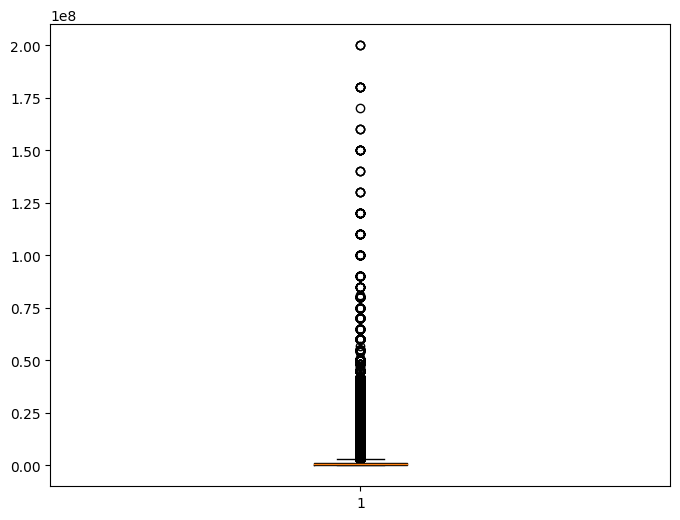

In [267]:
plt.figure(figsize=(8, 6))
plt.boxplot(players_with_val['market_value_in_eur'])
plt.show()

## 몸값으로 그룹화해서 분포 확인

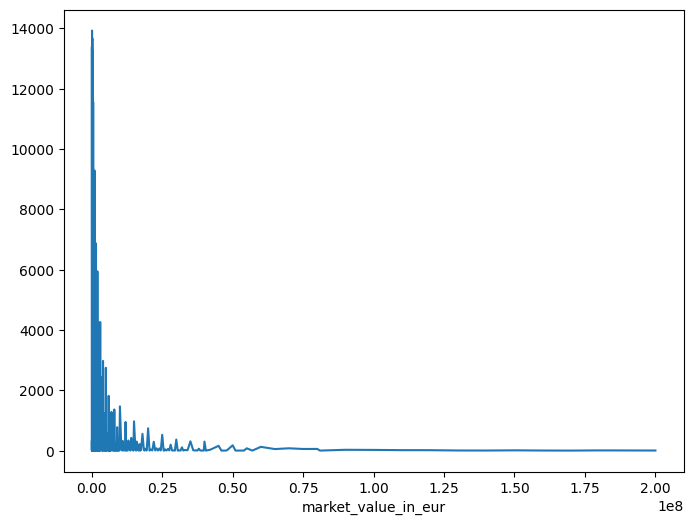

In [268]:
plt.figure(figsize=(8, 6))
players_with_val.groupby('market_value_in_eur')['player_id'].count().plot()
plt.show()

## 시간에 따른 몸값의 변화

### 합계

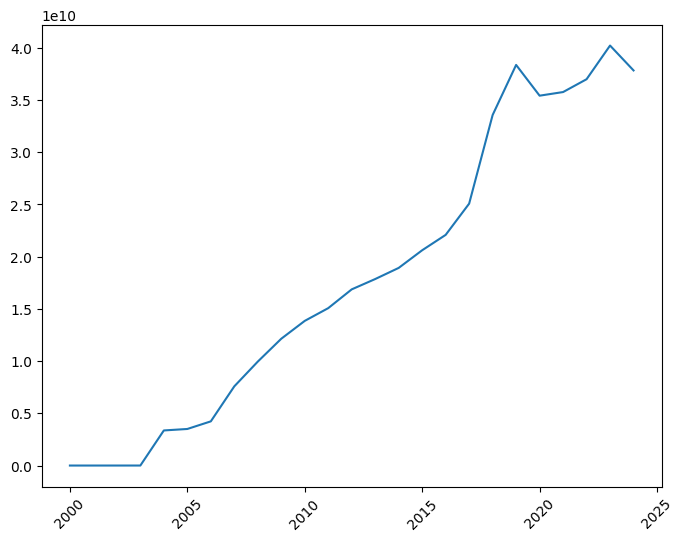

In [269]:
sum_per_year = players_with_val.groupby('dateyear')['market_value_in_eur'].sum()
x = sum_per_year.index
y = sum_per_year.values

plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.xticks(rotation=45)
plt.show()

### 최댓값

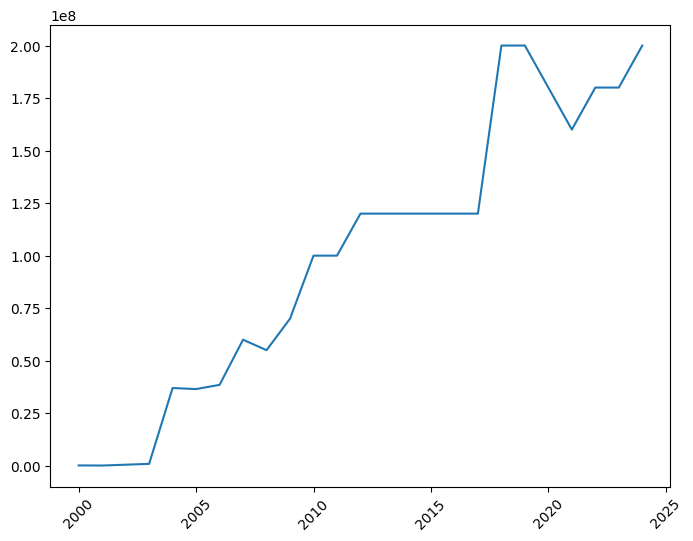

In [270]:
max_per_year = players_with_val.groupby('dateyear')['market_value_in_eur'].max()
x = max_per_year.index
y = max_per_year.values

plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.xticks(rotation=45)
plt.show()

### 평균

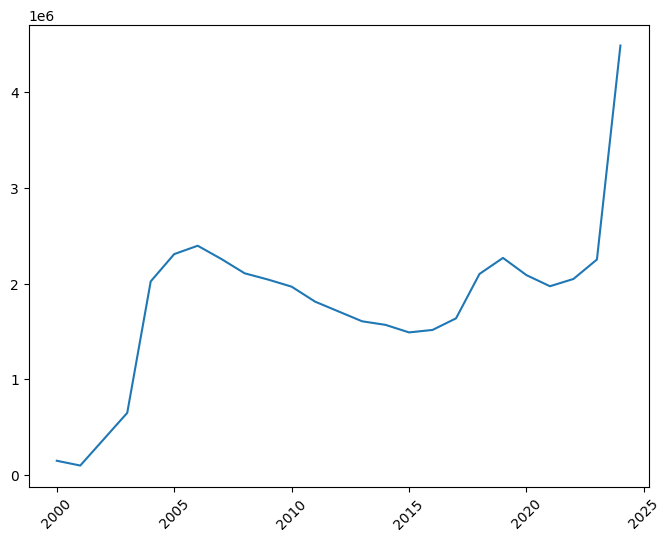

In [271]:
mean_per_year = players_with_val.groupby('dateyear')['market_value_in_eur'].mean()
x = mean_per_year.index
y = mean_per_year.values

plt.figure(figsize=(8, 6))
plt.plot(x, y)
plt.xticks(rotation=45)
plt.show()

### 연도별 데이터 수

연도별 몸값 평균이 2005년에 2015~2020년보다 높다. <br>
그 이유를 2005년 쯤 데이터의 수가 적기 때문이라고 추측하고 확인

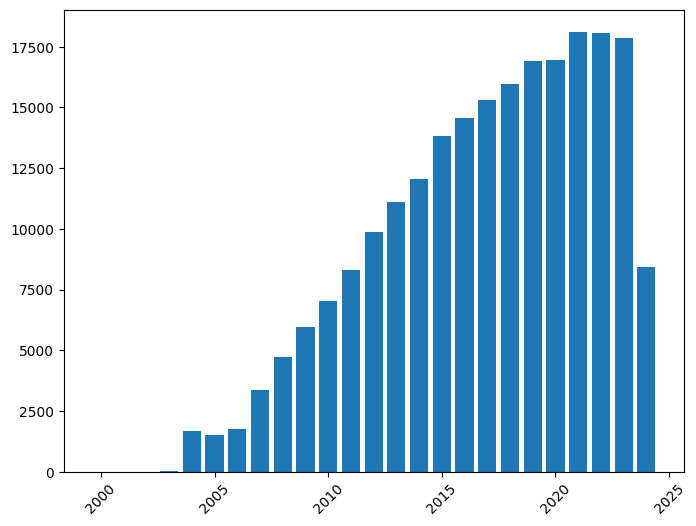

In [272]:
y = players_with_val.groupby('dateyear')['player_id'].count()

plt.figure(figsize=(8, 6))
plt.bar(x, y)
plt.xticks(rotation=45)
plt.show()

### 2013 - 2024년 까지 연도별 몸값 boxplot

In [273]:
players_with_val =  players_with_val[
    (players_with_val['dateyear'] >= 2013) & (players_with_val['dateyear'] <= 2024)
]

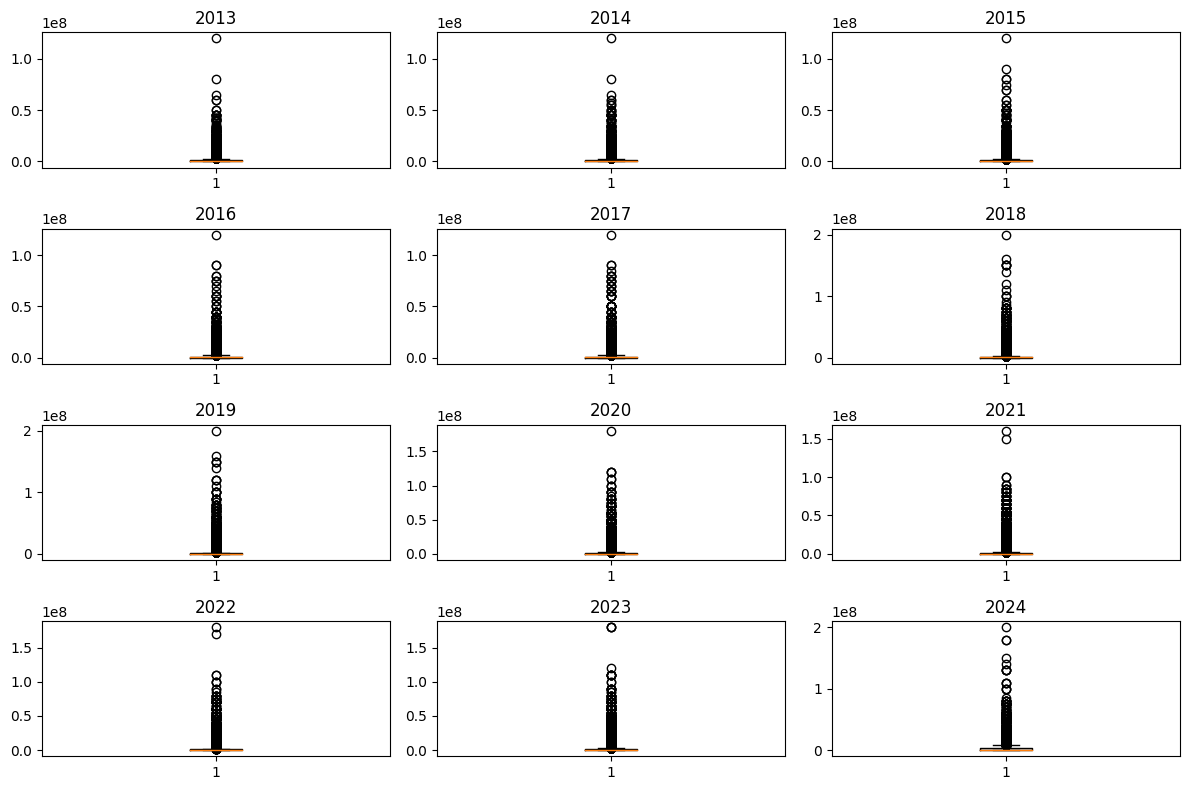

In [274]:
years = sorted(players_with_val['dateyear'].unique())

# 4개의 행으로 그리기 위한 설정
num_plots = len(years)
num_rows = 4
num_cols = (num_plots + 3) // 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

axes = axes.flatten() # 1차원 배열로 펴줌. 2중 for문 안쓰기 위해 사용

for i, year in enumerate(years):
    market_values = players_with_val[players_with_val['dateyear'] == year]['market_value_in_eur'].values
    
    ax = axes[i]
    ax.boxplot(market_values)
    ax.set_title(year)
    
# num_cols 설정에서 num_plots 보다 많은 도화지를 설정했는데, 빈 도화지를 삭제
for j in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes[j])    

plt.tight_layout()
plt.show()

연도에 상관없이 매년 축구선수의 몸값은 기준에 상회하는 초고가의 선수들이 있었음을 확인  

# 선수의 몸값과 다른 값들과의 상관관계 분석

## With Age 

In [275]:
players_with_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 179215 entries, 17 to 439973
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   player_id               179215 non-null  int64 
 1   current_club_id         179215 non-null  int64 
 2   first_name              179215 non-null  object
 3   last_name               179215 non-null  object
 4   name                    179215 non-null  object
 5   last_season             179215 non-null  int64 
 6   country_of_citizenship  179215 non-null  object
 7   city_of_birth           179215 non-null  object
 8   position                179215 non-null  object
 9   sub_position            179215 non-null  object
 10  dateyear                179215 non-null  int64 
 11  age                     179215 non-null  int64 
 12  market_value_in_eur     179215 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 19.1+ MB


### 나이에 따른 몸값의 변화 - bar

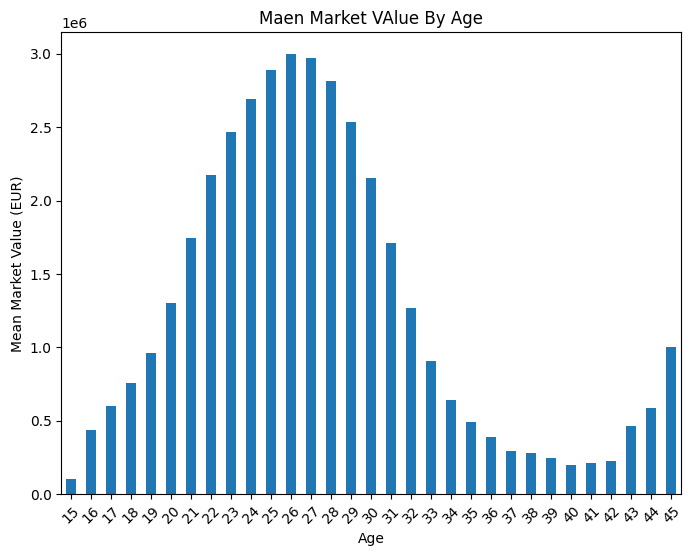

In [276]:
age_market_values = players_with_val.groupby('age')['market_value_in_eur'].mean()

plt.figure(figsize=(8, 6))
age_market_values.plot(kind='bar')
plt.xlabel('Age')
plt.ylabel('Mean Market Value (EUR)')
plt.title('Maen Market VAlue By Age')
plt.xticks(rotation=45)
plt.show()

43, 44, 45 세의 데이터의 수가 적어서 mean 이 높게 나온 것 같다고 추측하고 확인

In [277]:
display(players_with_val.groupby('age').count().tail())

,player_id,current_club_id,first_name,last_name,name,last_season,country_of_citizenship,city_of_birth,position,sub_position,dateyear,market_value_in_eur
age,,,,,,,,,,,,
41,79,79,79,79,79,79,79,79,79,79,79,79
42,38,38,38,38,38,38,38,38,38,38,38,38
43,6,6,6,6,6,6,6,6,6,6,6,6
44,4,4,4,4,4,4,4,4,4,4,4,4
45,1,1,1,1,1,1,1,1,1,1,1,1


#### 35세 이하의 데이터로만 몸값 변화 - bar

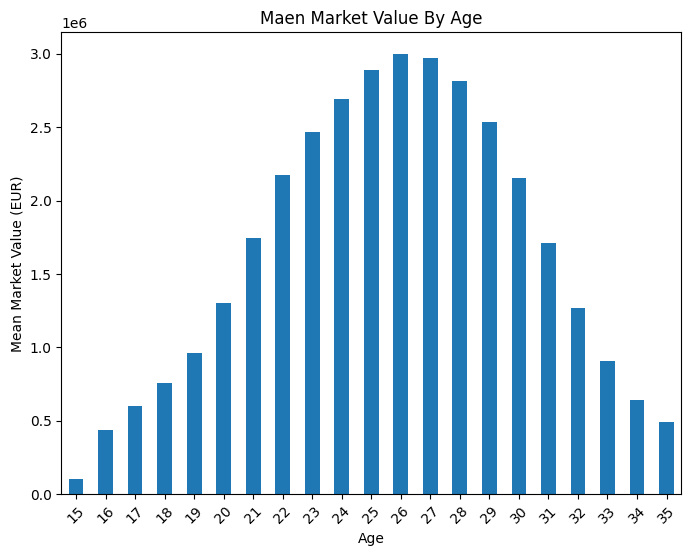

In [278]:
filtered_data = players_with_val[players_with_val['age'] <= 35]
age_market_values = filtered_data.groupby('age')['market_value_in_eur'].mean()

plt.figure(figsize=(8, 6))
age_market_values.plot(kind='bar')
plt.xlabel('Age')
plt.ylabel('Mean Market Value (EUR)')
plt.title('Maen Market Value By Age')
plt.xticks(rotation=45)
plt.show()

#### 가장 몸값이 비싼 나이 구간 Top5 - bar

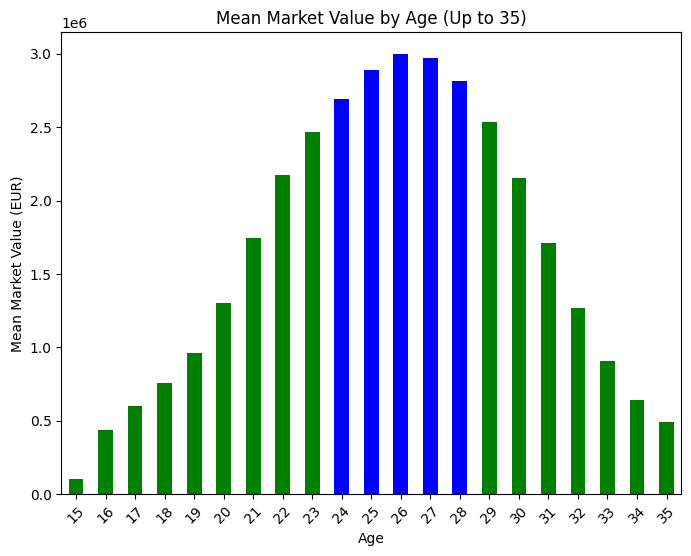

In [279]:
sorted_values = age_market_values.sort_values(ascending=False)

top_5_intervals = sorted_values.head(5).index

colors = ['blue' if age in top_5_intervals else 'green' for age in age_market_values.index]

plt.figure(figsize=(8, 6))
age_market_values.plot(kind='bar', color=colors)
plt.xlabel('Age')
plt.ylabel('Mean Market Value (EUR)')
plt.title('Mean Market Value by Age (Up to 35)')
plt.xticks(rotation=45)
plt.show()

#### 각 나이대 별로 가장 몸값이 비싼 선수

In [280]:
age_market_values.head()

age
15   103571.429
16   435025.707
17   603631.656
18   758835.867
19   962993.462
Name: market_value_in_eur, dtype: float64

In [281]:
sorted_values.head()

age
26   2996400.500
27   2973511.910
25   2888326.089
28   2811170.608
24   2689899.117
Name: market_value_in_eur, dtype: float64

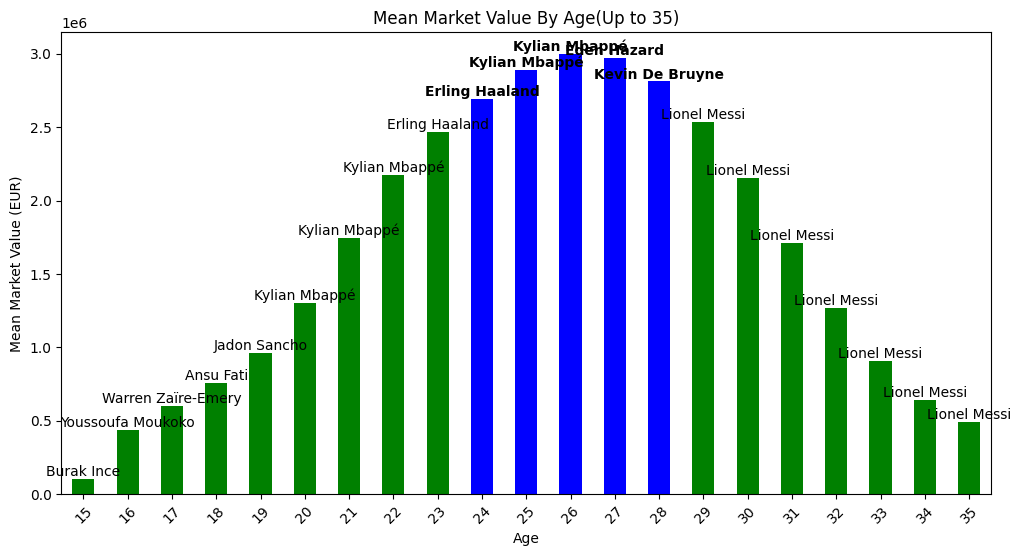

In [282]:
top_players = filtered_data.groupby('age').apply(
    lambda x: x.loc[x['market_value_in_eur'].idxmax()]['name'])

plt.figure(figsize=(12, 6))
age_market_values.plot(kind='bar', color=colors)
plt.xlabel('Age')
plt.ylabel('Mean Market Value (EUR)')
plt.title('Mean Market Value By Age(Up to 35)')

for i, value in enumerate(age_market_values):
    age = age_market_values.index[i]
    top_player = top_players[age]
    if age in sorted_values.head().index:
        plt.text(i, value, top_player, ha='center', va='bottom', color='black', fontweight='bold')
    else:
        plt.text(i, value, top_player, ha='center', va='bottom', color='black')
        
plt.xticks(rotation=45)
plt.show()

## With Position

### 어떤 포지션의 선수가 몸값이 비쌀까? - bar

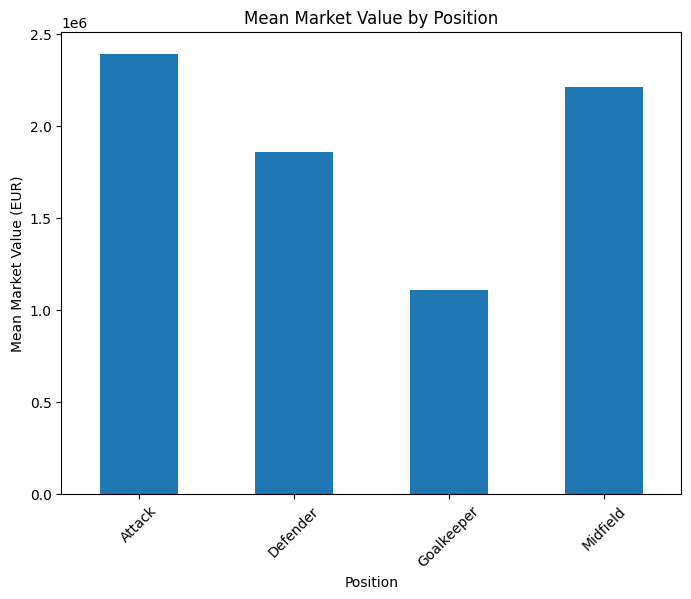

In [283]:
position_market_values = players_with_val.groupby('position')['market_value_in_eur'].mean()

plt.figure(figsize=(8, 6))
position_market_values.plot(kind='bar')
plt.xlabel('Position')
plt.ylabel('Mean Market Value (EUR)')
plt.title('Mean Market Value by Position')
plt.xticks(rotation=45)
plt.show()

공격수의 몸값이 가장 비싼 편

### 연도별, 포지션별 몸값 추이 - line

In [284]:
position_market_values = players_with_val.groupby(['position', 'dateyear'])['market_value_in_eur'].mean()
position_market_values = position_market_values.reset_index()
position_market_values.head()

,position,dateyear,market_value_in_eur
0,Attack,2013,1885235.955
1,Attack,2014,1871731.013
2,Attack,2015,1800784.741
3,Attack,2016,1828420.651
4,Attack,2017,2017140.288


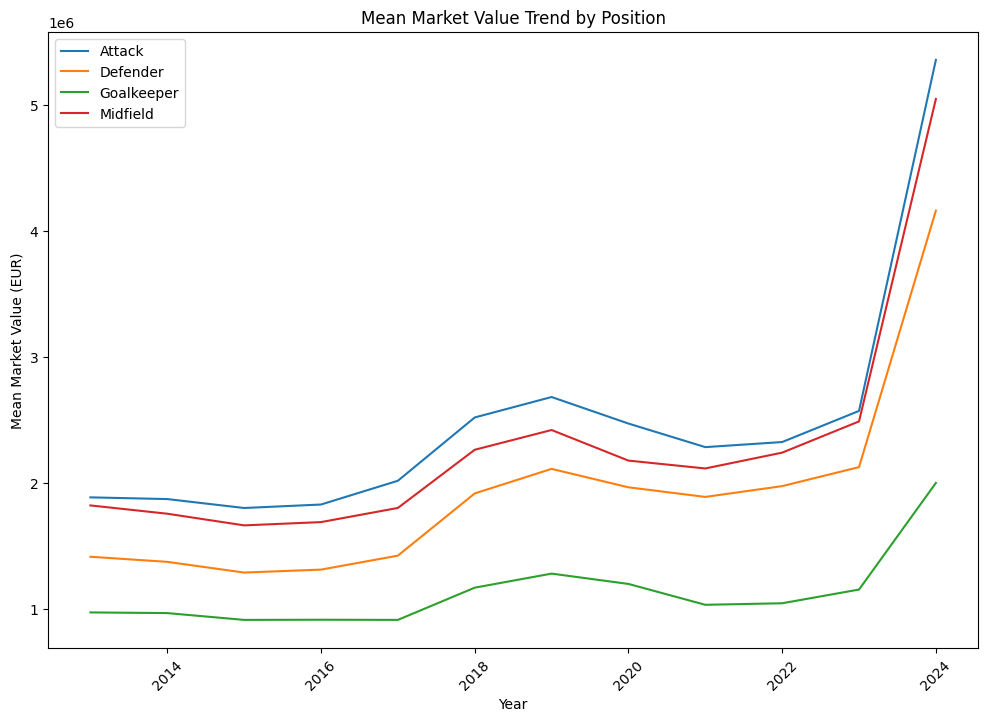

In [285]:
plt.figure(figsize=(12, 8))
for position in position_market_values['position'].unique():
    position_data = position_market_values[position_market_values['position'] == position]
    plt.plot(position_data['dateyear'], position_data['market_value_in_eur'], label=position)
    
plt.xlabel('Year')
plt.ylabel('Mean Market Value (EUR)')
plt.title('Mean Market Value Trend by Position')
plt.legend()
plt.xticks(rotation=45)
plt.show()

position끼리 연봉 추이가 비슷

### 서브 포지션 별 연봉 추이 비교 - line

In [286]:
positions = players_with_val['position'].unique()
positions

array(['Attack', 'Goalkeeper', 'Defender', 'Midfield'], dtype=object)

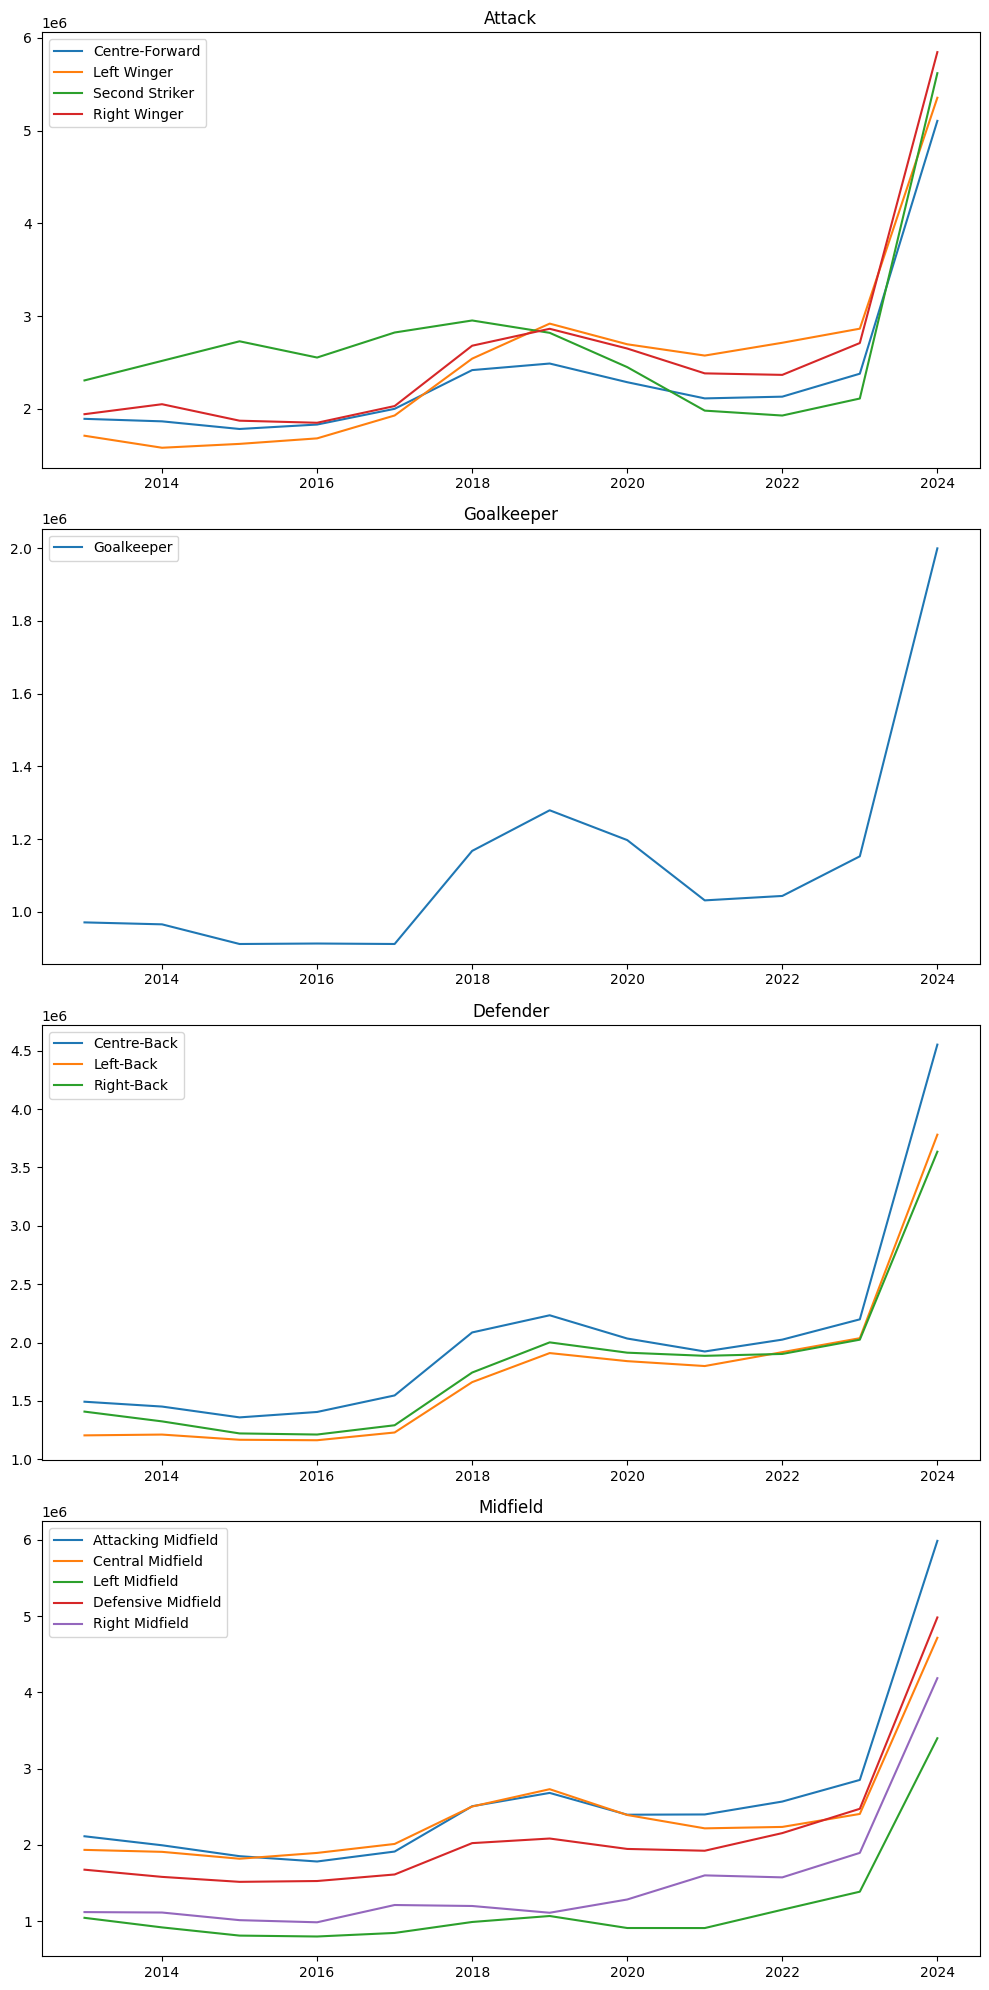

In [287]:
fig, axes = plt.subplots(len(positions), figsize=(10, 20))

for i, position in enumerate(positions):
    ax = axes[i]
    ax.set_title(position)
    
    position_data = players_with_val[players_with_val['position'] == position]
    sub_positions = position_data['sub_position'].unique()
    
    for sub_position in sub_positions:
        sub_position_data = position_data[position_data['sub_position'] == sub_position]
        sub_position_value = sub_position_data.groupby('dateyear')['market_value_in_eur'].mean()
        
        ax.plot(sub_position_value.index, sub_position_value.values, label=sub_position)
    
    ax.legend()
    
plt.tight_layout()
plt.show()

#### 그래프에 연도별 top_player 정보 추가

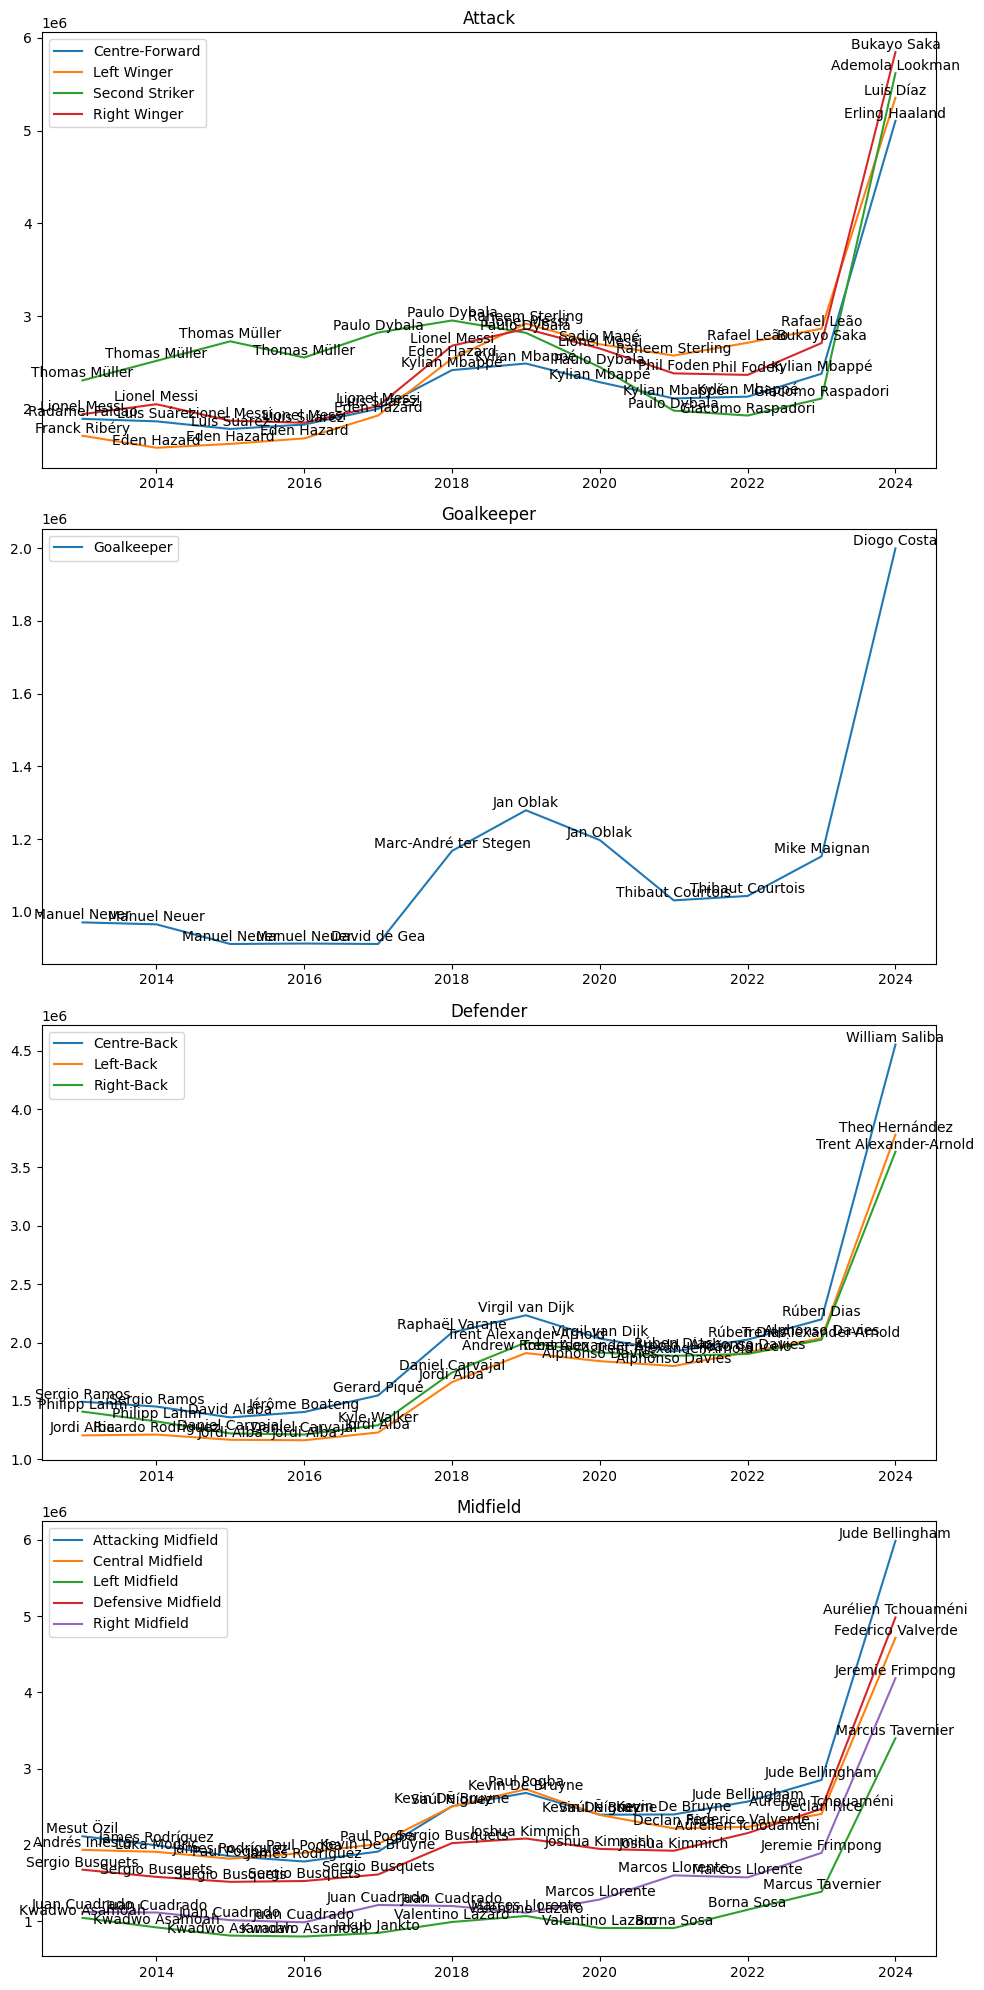

In [288]:
fig, axes = plt.subplots(len(positions), figsize=(10, 20))

for i, position in enumerate(positions):
    ax = axes[i]
    ax.set_title(position)
    
    position_data = players_with_val[players_with_val['position'] == position]
    sub_positions = position_data['sub_position'].unique()
    
    for sub_position in sub_positions:
        sub_position_data = position_data[position_data['sub_position'] == sub_position]
        sub_position_value = sub_position_data.groupby('dateyear')['market_value_in_eur'].mean()
        
        ax.plot(sub_position_value.index, sub_position_value.values, label=sub_position)
        
        top_players = sub_position_data.loc[sub_position_data.groupby('dateyear')['market_value_in_eur'].idxmax(), 'name']
        
        for year, player in zip(sub_position_value.index, top_players):
            ax.text(year, sub_position_value[year], player, ha='center', va='bottom')    
    ax.legend()
    
plt.tight_layout()
plt.show()

## With Country

### 국가별로 얼마나 많은 선수를 배출했는지 상위 10개국 - bar

In [289]:
players_with_val.drop_duplicates('player_id')['country_of_citizenship'].value_counts()

country_of_citizenship
Italy             1810
Spain             1733
France            1599
England           1377
Russia            1340
                  ... 
Seychelles           1
Tahiti               1
Réunion              1
Oman                 1
Southern Sudan       1
Name: count, Length: 183, dtype: int64

In [290]:
country_player_counts = players_with_val.drop_duplicates('player_id')['country_of_citizenship'].value_counts()
country_player_counts.sort_values(ascending=False)


country_of_citizenship
Italy             1810
Spain             1733
France            1599
England           1377
Russia            1340
                  ... 
Sint Maarten         1
Somalia              1
Korea, North         1
San Marino           1
Southern Sudan       1
Name: count, Length: 183, dtype: int64

In [291]:
top_10_countries = country_player_counts.head(10)
top_10_countries

country_of_citizenship
Italy          1810
Spain          1733
France         1599
England        1377
Russia         1340
Turkey         1316
Germany        1255
Netherlands    1249
Ukraine        1179
Greece          996
Name: count, dtype: int64

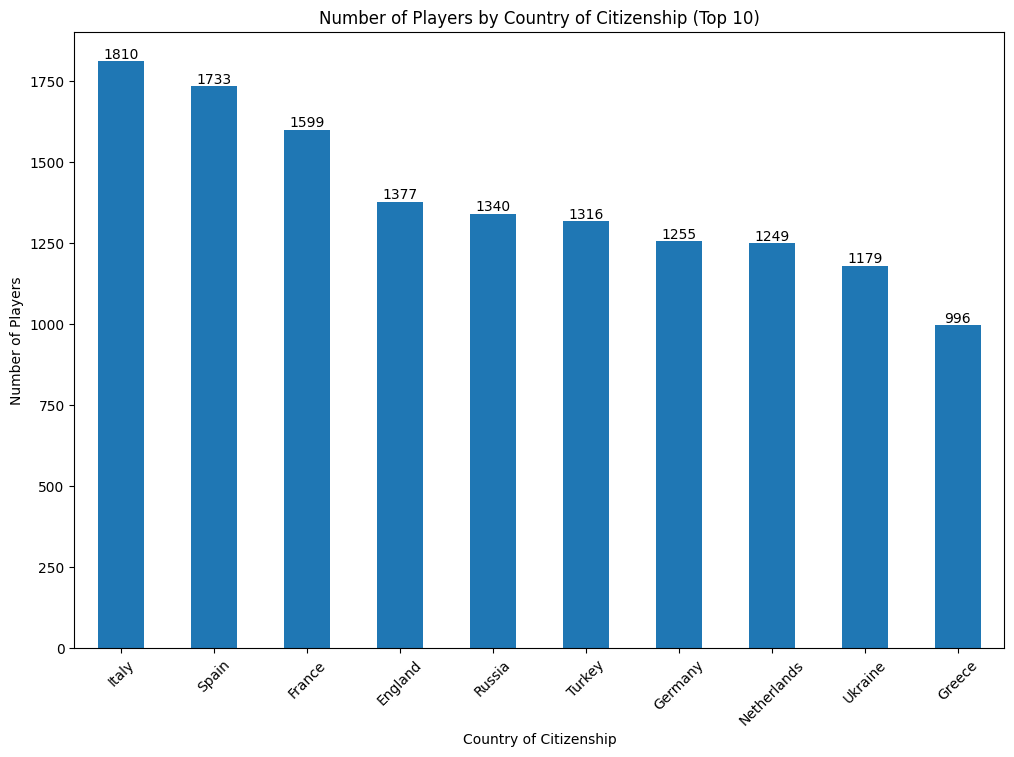

In [292]:
plt.figure(figsize=(12, 8))
top_10_countries.plot(kind='bar')
plt.xlabel('Country of Citizenship')
plt.ylabel('Number of Players')
plt.title('Number of Players by Country of Citizenship (Top 10)')

for i, value in enumerate(top_10_countries):
    country = top_10_countries.index[i]
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()

확실히 유럽 국가들이 많은 선수들을 배출하는 듯

#### 2024년만

In [293]:
country_player_counts_2024 = players_with_val_2024.drop_duplicates('player_id')['country_of_citizenship'].value_counts()
country_player_counts_2024

country_of_citizenship
Spain           415
France          372
Ukraine         340
Netherlands     320
Türkiye         313
               ... 
Libya             1
Latvia            1
Bonaire           1
Philippines       1
Sierra Leone      1
Name: count, Length: 135, dtype: int64

In [294]:
country_player_counts_2024.sort_values(ascending=False)

top_10_countries = country_player_counts_2024.head(10)
top_10_countries

country_of_citizenship
Spain          415
France         372
Ukraine        340
Netherlands    320
Türkiye        313
Germany        295
England        270
Russia         268
Italy          221
Portugal       210
Name: count, dtype: int64

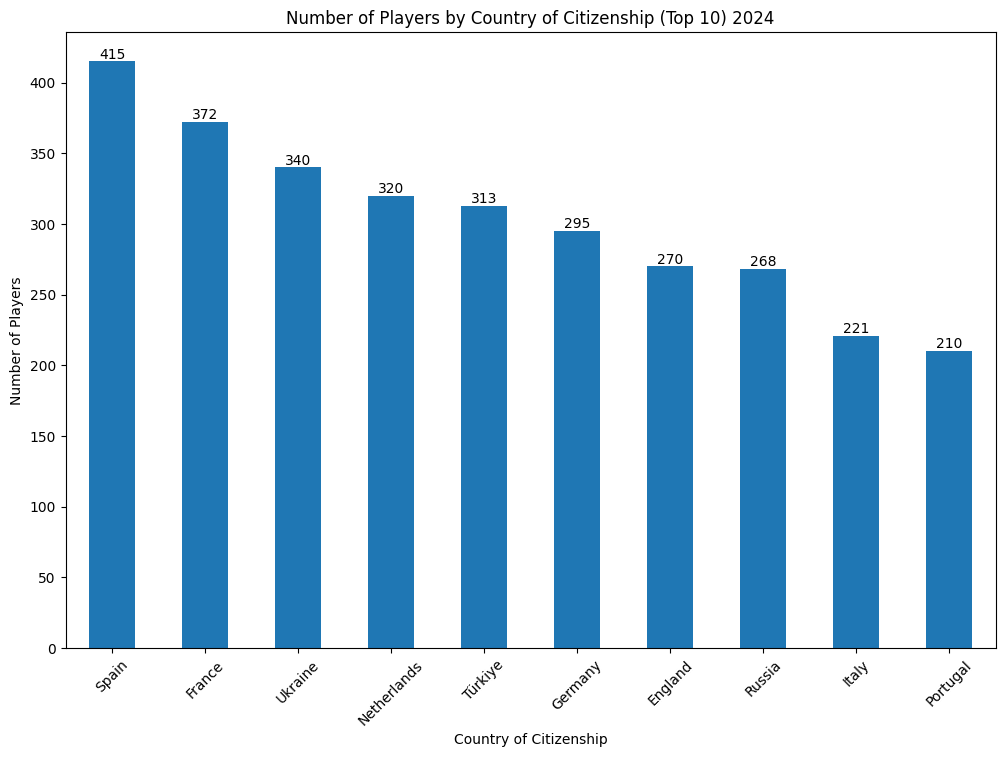

In [295]:
plt.figure(figsize=(12, 8))
top_10_countries.plot(kind='bar')
plt.xlabel('Country of Citizenship')
plt.ylabel('Number of Players')
plt.title('Number of Players by Country of Citizenship (Top 10) 2024')

for i, value in enumerate(top_10_countries):
    country = top_10_countries.index[i]
    plt.text(i, value, str(value), ha='center', va='bottom')
    
plt.xticks(rotation=45)
plt.show()

# 국가별 선수 배출 수 지도시각화

## 국가별 위도, 경도 값 수집(geopy)

`geopy`로 각 나라의 위도, 경도 값 얻고 locations_df 데이터프레임으로 저장

In [296]:
'''
locations = []
errors = []
geolocator = Nominatim(user_agent='my-app')
countries = country_player_counts.index

for country in countries:
    try:
        location = geolocator.geocode(country)
    except Exception as e:
        print(f'지오코딩 오류 - 나라: {country}. 오류 : {e}')
        errors.append(country)
        continue

    time.sleep(0.3)
    latitude = location.latitude
    longitude = location.longitude
    
    locations.append((country, latitude, longitude))
    print('나라:', country)
    print('위도:', latitude)
    print('경도:', longitude)
'''

In [297]:
# errors

In [298]:
'''
locations_df = pd.DataFrame(locations)
locations_df.rename(columns = {
    0: 'country',
    1: 'Latitude',
    2: 'Longitude'
}, inplace=True)

locations_df['player_count'] = locations_df.country.apply(lambda x: country_player_counts[x])
'''

In [299]:
''' 나라별 위도, 경도 다 가져오는데 너무 오래 걸려서 csv로 저장
locations_df.to_csv('./data/country_lat_lng.csv', index=False)
'''

In [300]:
locations_df = pd.read_csv('./data/country_lat_lng.csv')

In [301]:
locations_df.head()

,country,Latitude,Longitude,player_count
0,Italy,42.638,12.674,1810
1,Spain,39.326,-4.838,1733
2,France,46.603,1.888,1599
3,England,52.531,-1.265,1377
4,Russia,64.686,97.745,1340


## plotly

원래 `density_mapbox()`를 사용하려고 했는데, deprecated 되었다고 함

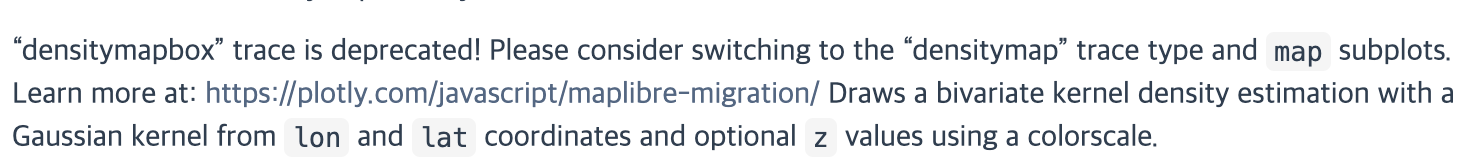

In [302]:
fig = px.density_map(
    locations_df, lat='Latitude', lon='Longitude', z='player_count', radius=15,
    center=dict(lat=0, lon=180), zoom=0,
    map_style="dark" 
)

fig.update_layout(
    title="Density Map of Players",
)

fig.show()


# 영국 도시별 선수 배출 수 시각화

In [303]:
cities_in_england = players_with_val[players_with_val['country_of_citizenship'] == 'England'].drop_duplicates('player_id')['city_of_birth']
print(f'Number of City in England: {len(cities_in_england.unique())}')

Number of City in England: 377


In [304]:
england_players_count = cities_in_england.value_counts()
england_players_count

city_of_birth
London               320
Manchester            60
Liverpool             54
Birmingham            45
Sheffield             20
                    ... 
Edgware                1
Grantham               1
Audenshaw              1
Hoyland                1
Palma de Mallorca      1
Name: count, Length: 377, dtype: int64

In [305]:
top_10_city_in_england = england_players_count.head(10)

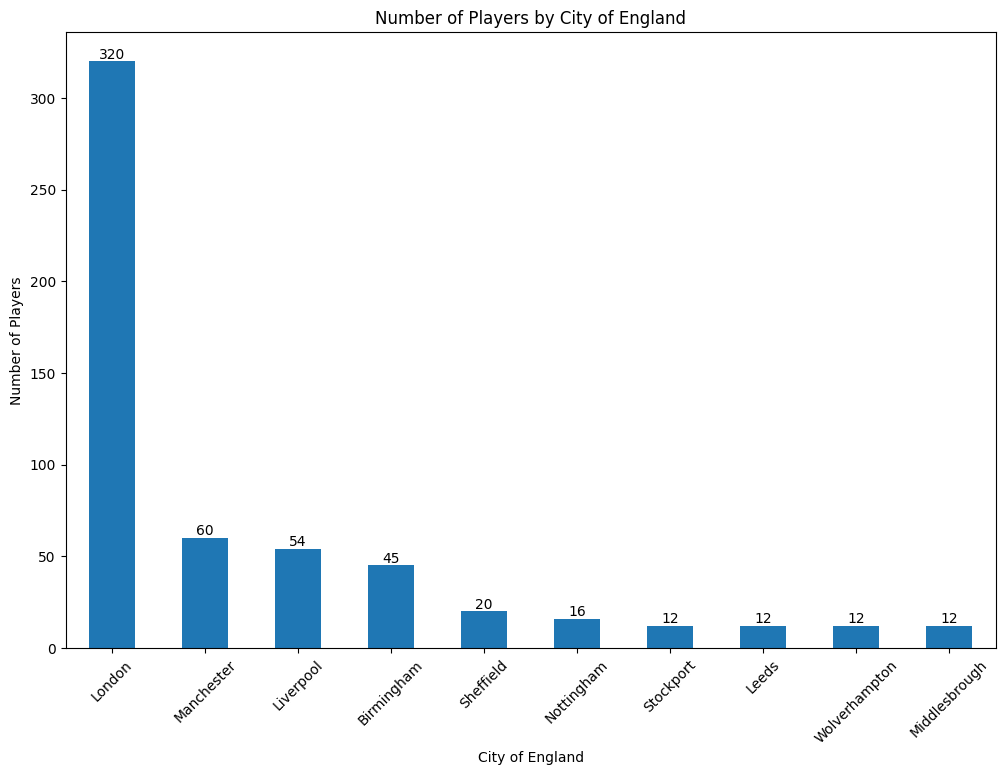

In [306]:
plt.figure(figsize=(12, 8))
top_10_city_in_england.plot(kind='bar')
plt.xlabel('City of England')
plt.ylabel('Number of Players')
plt.title('Number of Players by City of England')

for i, value in enumerate(top_10_city_in_england):
    city = top_10_city_in_england.index[i]
    plt.text(i, value, str(value), ha='center', va='bottom')
    
plt.xticks(rotation=45)
plt.show()

## 도시들의 위도, 경도 값 수집(geopy)

In [307]:
'''
top_50_city_in_england = england_players_count.head(50)

england_city_locations = []
errors = []

geolocator = Nominatim(user_agent='my-app')

cities = top_50_city_in_england.index

for city in cities:
    try:
        location = geolocator.geocode(city)
    except Exception as e:
        print(f'지오코딩 오류 - 나라: {city}. 오류: {e}')
        errors.append(city)
        continue
    
    time.sleep(0.3)
    latitude = location.latitude
    longitude = location.longitude
    
    england_city_locations.append((city, latitude, longitude))
'''

In [308]:
# errors

In [309]:
'''
england_locations_df = pd.DataFrame(england_city_locations)
england_locations_df.rename(columns={
    0: 'city',
    1: 'Latitude',
    2: 'Longitude'
}, inplace=True)
'''

In [310]:
'''
england_locations_df['player_count'] = england_locations_df.city.apply(lambda x: england_players_count[x])
'''

In [311]:
'''
england_locations_df.to_csv('./data/england_city_lat_lng.csv', index=False)
'''

In [312]:
england_locations_df = pd.read_csv('./data/england_city_lat_lng.csv')
england_locations_df.head()

,city,Latitude,Longitude,player_count
0,London,51.489,-0.144,320
1,Manchester,53.479,-2.245,60
2,Liverpool,53.407,-2.992,54
3,Birmingham,52.480,-1.903,45
4,Sheffield,53.381,-1.470,20


## 지도시각화(folium)

In [313]:
england_location = [55.8670, -4.2621]
england_map = folium.Map(location = england_location, zoom_start = 5)

for index, row in england_locations_df.iterrows():
    city = row['city']
    latitude = row['Latitude']
    longitude = row['Longitude']
    player_count = row['player_count']
    
    radius = player_count / 5
    color = 'darkred' if player_count > 100 else 'red' if player_count > 50 else 'lightred'
    folium.CircleMarker(
        location = [latitude, longitude],
        radius = radius,
        color = color,
        fill = True, 
        fill_color = color,
        fill_opacity = 0.6,
        tooltip=f'<b>{city}</b><br>Player Count: {player_count}'
    ).add_to(england_map)

england_map

## 영국 도시 연도별 선수 배출 수 애니메이션

In [314]:
df_for_animation = pd.DataFrame(
    players_with_val[players_with_val['country_of_citizenship'] == 'England']
    .groupby(['dateyear', 'city_of_birth'])['player_id']
    .count()
)

df_for_animation.reset_index(inplace=True)
df_for_animation.rename(
    columns={
        'city_of_birth': 'city',
        'player_id': 'player_count'
    }, inplace=True
)

df_for_animation = pd.merge(
    df_for_animation, england_locations_df[['city', 'Latitude', 'Longitude']],
    on='city', how='left'
)

df_for_animation.dropna(inplace=True)
df_for_animation.head()

,dateyear,city,player_count,Latitude,Longitude
12,2013,Bath,1,51.381,-2.360
15,2013,Birkenhead,2,53.390,-3.025
16,2013,Birmingham,18,52.480,-1.903
18,2013,Blackpool,1,53.818,-3.051
20,2013,Bolton,3,53.578,-2.430


In [315]:
fig = px.scatter_geo(
    df_for_animation,
    lat='Latitude',
    lon='Longitude',
    color='player_count',
    size='player_count', 
    hover_name='city',
    animation_frame='dateyear',
    projection='natural earth'
)

fig.update_geos(
    projection_scale=3.5, 
    scope='europe',
    center=dict(lat=55.8670, lon=-4.2621)
)

fig.update_layout(
    title='England Football Player Count By City Over Years',
    height=600, width=800
)

fig.show()

중남부 지역에서만 배출이 되고있음

# clubs, competitions 데이터 전처리

## clubs의 total_market_value 계산

In [316]:
clubs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439 entries, 0 to 438
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   club_id                  439 non-null    int64  
 1   club_code                439 non-null    object 
 2   name                     439 non-null    object 
 3   domestic_competition_id  439 non-null    object 
 4   total_market_value       0 non-null      float64
 5   squad_size               439 non-null    int64  
 6   average_age              401 non-null    float64
 7   foreigners_number        439 non-null    int64  
 8   foreigners_percentage    390 non-null    float64
 9   national_team_players    439 non-null    int64  
 10  stadium_name             439 non-null    object 
 11  stadium_seats            439 non-null    int64  
 12  net_transfer_record      439 non-null    object 
 13  coach_name               0 non-null      float64
 14  last_season              4

`total_market_value` 컬럼이 모두 결측치인데<br> 
이를 `players_with_val_2024` df의 `market_value_in_eur` 컬럼을 이용해 채워넣음

In [317]:
clubs_2024 = clubs[clubs['last_season'] == 2024]

In [318]:
players_with_val_2024.head()

,player_id,current_club_id,first_name,last_name,name,last_season,country_of_citizenship,city_of_birth,position,sub_position,dateyear,age,market_value_in_eur,market_value_rank
3919,3333,1237,James,Milner,James Milner,2024,England,Leeds,Midfield,Central Midfield,2024,38,1000000,3222.000
8470,5336,60949,Anastasios,Tsokanis,Anastasios Tsokanis,2024,Greece,Chalkida,Midfield,Defensive Midfield,2024,33,350000,4670.000
13499,7161,15,Jonas,Hofmann,Jonas Hofmann,2024,Germany,Heidelberg,Midfield,Attacking Midfield,2024,32,7000000,1186.000
15141,7825,1047,Pepe,Reina,Pepe Reina,2024,Spain,Madrid,Goalkeeper,Goalkeeper,2024,42,600000,3971.000
19028,11530,3205,Lionel,Carole,Lionel Carole,2024,France,Montreuil,Defender,Left-Back,2024,33,550000,4132.000


In [319]:
total_market_values = players_with_val_2024.groupby('current_club_id')['market_value_in_eur'].sum()
clubs_2024['total_market_value'] = clubs_2024['club_id'].apply(lambda club_id: total_market_values[club_id])

/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_7601/961770915.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [320]:
clubs_2024.head()

,club_id,club_code,name,domestic_competition_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,coach_name,last_season,filename,url
2,114,besiktas-istanbul,Beşiktaş Jimnastik Kulübü,TR1,117475000,31,26.400,16,51.600,7,Tüpraş Stadyumu,42445,€-18.65m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/besiktas-istan...
3,12,as-rom,Associazione Sportiva Roma,IT1,324500000,26,26.400,19,73.100,18,Olimpico di Roma,70634,€-65.60m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/as-rom/startse...
4,148,tottenham-hotspur,Tottenham Hotspur Football Club,GB1,750300000,27,25.500,18,66.700,17,Tottenham Hotspur Stadium,62850,€-93.55m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/tottenham-hots...
5,157,kaa-gent,Koninklijke Atletiek Associatie Gent,BE1,74500000,29,25.100,20,69.000,7,Planet Group Arena,20185,+€9.58m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/kaa-gent/start...
7,190,fc-kopenhagen,Football Club København,DK1,64500000,28,26.000,18,64.300,9,Parken,38065,+€37.06m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/fc-kopenhagen/...


## competitions 에서 필요한 컬럼만 추출

In [321]:
columns = ['competition_id', 'name', 'country_name']
filtered_competitions = competitions[columns].rename(columns={'competition_id': 'domestic_competition_id'})

In [322]:
filtered_competitions.head()

,domestic_competition_id,name,country_name
0,CIT,italy-cup,Italy
1,NLSC,johan-cruijff-schaal,Netherlands
2,GRP,kypello-elladas,Greece
3,POSU,supertaca-candido-de-oliveira,Portugal
4,RUSS,russian-super-cup,Russia


## club + competition merge

In [323]:
clubs_competitions_2024 = pd.merge(clubs_2024, filtered_competitions, on='domestic_competition_id')

display(clubs_competitions_2024.head())
print(clubs_competitions_2024.info())

,club_id,club_code,name_x,domestic_competition_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,coach_name,last_season,filename,url,name_y,country_name
0,114,besiktas-istanbul,Beşiktaş Jimnastik Kulübü,TR1,117475000,31,26.400,16,51.600,7,Tüpraş Stadyumu,42445,€-18.65m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/besiktas-istan...,super-lig,Turkey
1,449,trabzonspor,Trabzonspor Kulübü,TR1,99150000,32,26.200,14,43.800,11,Papara Park,41131,€-18.31m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/trabzonspor/st...,super-lig,Turkey
2,6890,istanbul-basaksehir-fk,İstanbul Başakşehir Futbol Kulübü,TR1,47575000,29,27.000,13,44.800,6,Başakşehir Fatih Terim,17156,€-2.70m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/istanbul-basak...,super-lig,Turkey
3,141,galatasaray-istanbul,Galatasaray Spor Kulübü,TR1,262050000,28,26.700,16,57.100,12,Ali Sami Yen Spor Kompleksi RAMS Park,52468,€-36k,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/galatasaray-is...,super-lig,Turkey
4,44006,bodrumspor,Bodrumspor Spor Faaliyetleri Anonim Şirketi,TR1,19700000,32,26.800,12,37.500,5,Grey Beton Bodrum Stadyumu,4243,€-2.19m,NaN,2024,../data/raw/transfermarkt-scraper/2024/clubs.j...,https://www.transfermarkt.co.uk/bodrumspor/sta...,super-lig,Turkey


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   club_id                  237 non-null    int64  
 1   club_code                237 non-null    object 
 2   name_x                   237 non-null    object 
 3   domestic_competition_id  237 non-null    object 
 4   total_market_value       237 non-null    int64  
 5   squad_size               237 non-null    int64  
 6   average_age              237 non-null    float64
 7   foreigners_number        237 non-null    int64  
 8   foreigners_percentage    235 non-null    float64
 9   national_team_players    237 non-null    int64  
 10  stadium_name             237 non-null    object 
 11  stadium_seats            237 non-null    int64  
 12  net_transfer_record      237 non-null    object 
 13  coach_name               0 non-null      float64
 14  last_season              2

## 컬럼 정리

In [324]:
columns = ['club_id', 'club_code', 'name_x', 'total_market_value', 'squad_size', 'average_age', 'foreigners_number', 'foreigners_percentage', 'name_y', 'country_name']

filtered_clubs_competitions_2024 = clubs_competitions_2024[columns]
filtered_clubs_competitions_2024.rename(columns={
    "name_x": "club_name",
    "name_y": "competition_name"
}, inplace=True)

filtered_clubs_competitions_2024.head()

/var/folders/fs/9jclkm_s0_7cvyj9prcm0z6r0000gn/T/ipykernel_7601/4225875527.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,club_id,club_code,club_name,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,competition_name,country_name
0,114,besiktas-istanbul,Beşiktaş Jimnastik Kulübü,117475000,31,26.400,16,51.600,super-lig,Turkey
1,449,trabzonspor,Trabzonspor Kulübü,99150000,32,26.200,14,43.800,super-lig,Turkey
2,6890,istanbul-basaksehir-fk,İstanbul Başakşehir Futbol Kulübü,47575000,29,27.000,13,44.800,super-lig,Turkey
3,141,galatasaray-istanbul,Galatasaray Spor Kulübü,262050000,28,26.700,16,57.100,super-lig,Turkey
4,44006,bodrumspor,Bodrumspor Spor Faaliyetleri Anonim Şirketi,19700000,32,26.800,12,37.500,super-lig,Turkey


# 국가별 클럽별 시장 가치 시각화

### treemap

In [325]:
sorted_clubs_competitions_2024 = filtered_clubs_competitions_2024.sort_values('total_market_value', ascending=False)

fig = px.treemap(
    sorted_clubs_competitions_2024,
    path=['country_name', 'club_name'],
    values='total_market_value',
    labels={
        'club_name': 'Club Name',
        'total_market_value': 'Total Market Value'
    },
    title='Clubs in 2024 by Total Market Value'
)

fig.show()

### bar

In [326]:
fig = px.bar(
    sorted_clubs_competitions_2024,
    x='club_name', 
    y='total_market_value',
    color='country_name', 
    labels={
        'club_name': 'Club Name',
        'total_market_value': 'Total Market Value'
    },
    title='Clubs in 2024 by Total Market Value'
)

fig.show()

# 리그(국가) 별로 팀 간 '몸값' 분포 정도 - boxplot

In [327]:
fig = px.box(
    sorted_clubs_competitions_2024,
    x='competition_name',
    y='total_market_value',
    color='competition_name',
    title='Market Value Distribution by Dompetition(Domestic League)',
    labels={
        'competition_name': 'Competition',
        'total_market_value': 'Total Market Value'
    }
)

fig.show()

# 리그(국가) 별로 팀 간 '나이' 분포 정도 - boxplot

In [328]:
fig = px.box(
    sorted_clubs_competitions_2024,
    x='competition_name',
    y='average_age',
    color='competition_name',
    title='Age Distribution by Dompetition(Domestic League)',
    labels={
        'competition_name': 'Competition',
        'average_age': 'Average Age'
    }
)

fig.show()

# 경기장 내의 기록과 몸값의 상관관계 분석

경기장 내의 기록과 몸값의 상관관계를 분석하기 위해 `경기장 내의 기록`을<br>
 whoscored(https://1xbet.whoscored.com/)에서 scraping 함

## Data Scraping

### Functions

#### 모든 팝업창 닫기

In [329]:
def close_popups():
    pages = driver.window_handles

    for i in pages:
        if i != pages[0]:
            driver.switch_to.window(i)
            driver.close()
    
    driver.switch_to.window(pages[0])

### 상위 5대 리그만 선택

In [330]:
competition_mkt_val_sum = sorted_clubs_competitions_2024.groupby('competition_name')['total_market_value'].sum()
top_5_competition = competition_mkt_val_sum.sort_values(ascending=False).head(5).index

In [331]:
top_5_club_ids = sorted_clubs_competitions_2024[sorted_clubs_competitions_2024['competition_name'].isin(top_5_competition)]['club_id'].unique()
top_5_club_ids

array([   11,   418,   281,   631,    27,    31,   985,   583,   148,
          46,    15,   762,   405,   131,     5, 23826,  1237,    13,
          16,   506,   681,  6195,  1148,   873,   800,   379,   989,
         162,   621,   543,   703,    12,   931,    29,    79,   180,
        1082,  1025,  1003,   244,    24,   430,   677,  1049,  1041,
        1050,   417, 12321,   398,    82,   667,   826,   273,   416,
          60,   368,   533,    18,  1421,   252,   130,  3911,    86,
         410,    89,   150,   331,   472,  1047,   167,    39,  2919,
         995,   237,  1005,   276,   940,  1108,   415,   969,   714,
         367,  1390,   749,   738,  3709,  2036,   290,  1244,   618,
          80,   607,    35,   366,  1420,   269])

### 상위 5대 리그에 뛰고 있는 선수들만 선택

골키퍼는 제외

In [332]:
columns = ['player_id', 'current_club_id', 'first_name', 'last_name', 'name', 'position', 'sub_position', 'age', 'market_value_in_eur']

players_with_stats = players_with_val_2024[players_with_val_2024['current_club_id'].isin(top_5_club_ids)][columns]
players_with_stats = players_with_stats[players_with_stats['position'] != 'Goalkeeper']

In [333]:
players_with_stats['current_club_name'] = players_with_stats['current_club_id'].map(sorted_clubs_competitions_2024.set_index('club_id')['club_name'])
players_with_stats['competition_name'] = players_with_stats['current_club_id'].map(sorted_clubs_competitions_2024.set_index('club_id')['competition_name'])
players_with_stats = players_with_stats.sort_values(by='market_value_in_eur', ascending=False)
players_with_stats.head()

,player_id,current_club_id,first_name,last_name,name,position,sub_position,age,market_value_in_eur,current_club_name,competition_name
375317,418560,281,Erling,Haaland,Erling Haaland,Attack,Centre-Forward,24,200000000,Manchester City Football Club,premier-league
343320,342229,418,Kylian,Mbappé,Kylian Mbappé,Attack,Centre-Forward,26,180000000,Real Madrid Club de Fútbol,laliga
411866,581678,418,Jude,Bellingham,Jude Bellingham,Midfield,Attacking Midfield,21,180000000,Real Madrid Club de Fútbol,laliga
379752,433177,11,Bukayo,Saka,Bukayo Saka,Attack,Right Winger,23,150000000,Arsenal Football Club,premier-league
372158,406635,281,Phil,Foden,Phil Foden,Attack,Right Winger,24,140000000,Manchester City Football Club,premier-league


### 포지션 별 데이터프레임 분리

포지션 별로 기록을 가져오기 때문에 포지션별로 데이터프레임을 분리

In [334]:
attack_df = players_with_stats[players_with_stats['position'] == 'Attack'].reset_index(drop=True)
attack_df

,player_id,current_club_id,first_name,last_name,name,position,sub_position,age,market_value_in_eur,current_club_name,competition_name
0,418560,281,Erling,Haaland,Erling Haaland,Attack,Centre-Forward,24,200000000,Manchester City Football Club,premier-league
1,342229,418,Kylian,Mbappé,Kylian Mbappé,Attack,Centre-Forward,26,180000000,Real Madrid Club de Fútbol,laliga
2,433177,11,Bukayo,Saka,Bukayo Saka,Attack,Right Winger,23,150000000,Arsenal Football Club,premier-league
3,406635,281,Phil,Foden,Phil Foden,Attack,Right Winger,24,140000000,Manchester City Football Club,premier-league
4,406625,46,Lautaro,Martínez,Lautaro Martínez,Attack,Centre-Forward,27,110000000,Football Club Internazionale Milano S.p.A.,serie-a
...,...,...,...,...,...,...,...,...,...,...,...
636,88647,35,Andreas,Albers,Andreas Albers,Attack,Centre-Forward,34,300000,Fußball-Club St. Pauli von 1910,bundesliga
637,883122,130,Anas,Haj Mohamed,Anas Haj Mohamed,Attack,Right Winger,19,200000,Parma Calcio 1913,serie-a
638,412934,290,Eros,Maddy,Eros Maddy,Attack,Right Winger,23,200000,Association de la Jeunesse auxerroise,ligue-1
639,834744,714,Antoniu,Roca,Antoniu Roca,Attack,Right Winger,22,200000,Reial Club Deportiu Espanyol de Barcelona S.A.D.,laliga


In [335]:
midfield_df = players_with_stats[players_with_stats['position'] == 'Midfield'].reset_index(drop=True)
midfield_df

,player_id,current_club_id,first_name,last_name,name,position,sub_position,age,market_value_in_eur,current_club_name,competition_name
0,581678,418,Jude,Bellingham,Jude Bellingham,Midfield,Attacking Midfield,21,180000000,Real Madrid Club de Fútbol,laliga
1,598577,15,Florian,Wirtz,Florian Wirtz,Midfield,Attacking Midfield,21,130000000,Bayer 04 Leverkusen Fußball,bundesliga
2,580195,27,Jamal,Musiala,Jamal Musiala,Midfield,Attacking Midfield,21,130000000,FC Bayern München,bundesliga
3,369081,418,Federico,Valverde,Federico Valverde,Midfield,Central Midfield,26,130000000,Real Madrid Club de Fútbol,laliga
4,568177,631,Cole,Palmer,Cole Palmer,Midfield,Attacking Midfield,22,130000000,Chelsea Football Club,premier-league
...,...,...,...,...,...,...,...,...,...,...,...
705,917817,826,Tom,Pouilly,Tom Pouilly,Midfield,Defensive Midfield,21,100000,Racing Club de Lens,ligue-1
706,1004619,995,Dehmaine,Tabibou,Dehmaine Tabibou,Midfield,Central Midfield,19,100000,Football Club de Nantes,ligue-1
707,931160,273,Djaoui,Cissé,Djaoui Cissé,Midfield,Central Midfield,20,100000,Stade Rennais Football Club,ligue-1
708,834468,398,Cristo,Muñoz,Cristo Muñoz,Midfield,Attacking Midfield,19,50000,Società Sportiva Lazio S.p.A.,serie-a


In [336]:
defender_df = players_with_stats[players_with_stats['position'] == 'Defender'].reset_index(drop=True)
defender_df

,player_id,current_club_id,first_name,last_name,name,position,sub_position,age,market_value_in_eur,current_club_name,competition_name
0,495666,11,William,Saliba,William Saliba,Defender,Centre-Back,23,80000000,Arsenal Football Club,premier-league
1,258004,281,Rúben,Dias,Rúben Dias,Defender,Centre-Back,27,75000000,Manchester City Football Club,premier-league
2,475959,281,Josko,Gvardiol,Josko Gvardiol,Defender,Centre-Back,22,75000000,Manchester City Football Club,premier-league
3,314353,31,Trent,Alexander-Arnold,Trent Alexander-Arnold,Defender,Right-Back,26,75000000,Liverpool Football Club,premier-league
4,435338,11,Gabriel,Magalhães,Gabriel Magalhães,Defender,Centre-Back,27,75000000,Arsenal Football Club,premier-league
...,...,...,...,...,...,...,...,...,...,...,...
816,923945,167,Noahkai,Banks,Noahkai Banks,Defender,Centre-Back,18,150000,Fußball-Club Augsburg 1907,bundesliga
817,914890,35,Muhammad,Dahaba,Muhammad Dahaba,Defender,Centre-Back,19,125000,Fußball-Club St. Pauli von 1910,bundesliga
818,802987,1041,Irvyn,Lomami,Irvyn Lomami,Defender,Right-Back,21,100000,Olympique Lyonnais,ligue-1
819,565846,1237,Imari,Samuels,Imari Samuels,Defender,Left-Back,21,100000,Brighton and Hove Albion Football Club,premier-league


### 상위 5대 리그 whoscored url 저장

In [568]:
top_5_competition

Index(['premier-league', 'serie-a', 'laliga', 'bundesliga', 'ligue-1'], dtype='object', name='competition_name')

In [597]:
urls = [
    "https://1xbet.whoscored.com/Regions/252/Tournaments/2/Seasons/10316/Stages/23400/PlayerStatistics/England-Premier-League-2024-2025",
    "https://1xbet.whoscored.com/Regions/108/Tournaments/5/Seasons/10375/Stages/23490/PlayerStatistics/Italy-Serie-A-2024-2025",
    "https://1xbet.whoscored.com/Regions/206/Tournaments/4/Seasons/10317/Stages/23401/PlayerStatistics/Spain-LaLiga-2024-2025",
    "https://1xbet.whoscored.com/Regions/81/Tournaments/3/Seasons/10365/Stages/23471/PlayerStatistics/Germany-Bundesliga-2024-2025",
    "https://1xbet.whoscored.com/Regions/74/Tournaments/22/Seasons/10329/Stages/23414/PlayerStatistics/France-Ligue-1-2024-2025"
]

In [567]:
position_df_dict = {
    "Offensive": attack_df,
    "Passing": midfield_df,
    "Defensive": defender_df
}

In [598]:
'''
for url in urls:
    driver = webdriver.Chrome()

    driver.get(url)

    driver.maximize_window()
    close_popups()   
    driver.execute_script("window.scrollTo(0,700)")
    time.sleep(1.5)

    for i in range(3):
        positions = driver.find_elements(By.CLASS_NAME, "in-squad-detailed-view")[:-1]
        position = positions[i]
        position.click()
        time.sleep(1.5)

        key = position.text.strip()
        df = position_df_dict[key]
        player_names = df['name'].unique()

        apps = driver.find_elements(By.ID, 'apps')[-1]
        all_players = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable(apps.find_elements(By.CLASS_NAME, 'option')[-1])
        )
        all_players.click()
        time.sleep(1.5)

        total_pages = int(driver.find_elements(By.ID, "totalPages")[-1].get_attribute('value'))
        for _ in range(total_pages):
            html = driver.page_source
            soup = BeautifulSoup(html, 'html.parser')

            table = str(soup.select_one('#statistics-table-' + str.lower(key)))
            stats_table = pd.read_html(table)[0].iloc[:,1:]

            for idx, row in stats_table.iterrows():
                player_info = row['Player.1'].split(' ')
                player_name = ' '.join(player_info[:2])

                if player_name in player_names:
                    player_row = df[df['name'] == player_name].iloc[0]
                    df.loc[player_row.name, stats_table.columns[1:]] = row[1:]
                    
            time.sleep(1)
            
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable(driver.find_elements(By.ID, "next")[-1])
            )
            next_button.click() 
            time.sleep(1.5)
    
    driver.quit()
    time.sleep(2)
'''

### scraping 결과 csv 로 저장

In [ ]:
'''
attack_df.to_csv('./data/attack_webscraping.csv', index=False)
midfield_df.to_csv('./data/midfield_webscraping.csv', index=False)
defender_df.to_csv('./data/defender_webscraping.csv', index=False)
'''

### scraping 결과 불러오기

In [646]:
attack_df = pd.read_csv('./data/attack_webscraping.csv')
midfield_df = pd.read_csv('./data/midfield_webscraping.csv')
defender_df = pd.read_csv('./data/defender_webscraping.csv')

In [647]:
display(attack_df.head())
display(midfield_df.head())
display(defender_df.head())

,player_id,current_club_id,first_name,last_name,name,position,sub_position,age,market_value_in_eur,current_club_name,...,OwnG,Rating,Goals,Assists,SpG,KeyP,Fouled,Off,Disp,UnsTch
0,418560,281,Erling,Haaland,Erling Haaland,Attack,Centre-Forward,24,200000000,Manchester City Football Club,...,NaN,7.370,13,1,4.4,0.8,0.6,0.1,1.1,1.6
1,342229,418,Kylian,Mbappé,Kylian Mbappé,Attack,Centre-Forward,26,180000000,Real Madrid Club de Fútbol,...,NaN,7.360,9,1,4.6,1,1.1,1.5,1.2,2.7
2,433177,11,Bukayo,Saka,Bukayo Saka,Attack,Right Winger,23,150000000,Arsenal Football Club,...,NaN,7.900,5,10,3.1,2.8,2.1,0.2,2.3,1.5
3,406635,281,Phil,Foden,Phil Foden,Attack,Right Winger,24,140000000,Manchester City Football Club,...,NaN,6.530,-,1,2.2,1.7,1.3,0.2,1.2,1.3
4,406625,46,Lautaro,Martínez,Lautaro Martínez,Attack,Centre-Forward,27,110000000,Football Club Internazionale Milano S.p.A.,...,NaN,7.100,5,2,2.7,1.2,1.2,0.8,1.5,1.8


,player_id,current_club_id,first_name,last_name,name,position,sub_position,age,market_value_in_eur,current_club_name,...,Blocks,OwnG,Rating,Assists,KeyP,AvgP,PS%,Crosses,LongB,ThrB
0,581678,418,Jude,Bellingham,Jude Bellingham,Midfield,Attacking Midfield,21,180000000,Real Madrid Club de Fútbol,...,NaN,NaN,7.370,4,1.2,49.3,88.8,-,1.6,0.2
1,598577,15,Florian,Wirtz,Florian Wirtz,Midfield,Attacking Midfield,21,130000000,Bayer 04 Leverkusen Fußball,...,NaN,NaN,7.700,4,2,61.0,84.1,0.6,1.2,0.3
2,580195,27,Jamal,Musiala,Jamal Musiala,Midfield,Attacking Midfield,21,130000000,FC Bayern München,...,NaN,NaN,7.800,1,1.7,39.4,82.7,-,0.6,0.3
3,369081,418,Federico,Valverde,Federico Valverde,Midfield,Central Midfield,26,130000000,Real Madrid Club de Fútbol,...,NaN,NaN,7.290,2,1.1,61.4,90.3,-,4,0.1
4,568177,631,Cole,Palmer,Cole Palmer,Midfield,Attacking Midfield,22,130000000,Chelsea Football Club,...,NaN,NaN,7.660,6,2.8,34.8,81.5,1.1,2.8,0.4


,player_id,current_club_id,first_name,last_name,name,position,sub_position,age,market_value_in_eur,current_club_name,...,Mins,Tackles,Inter,Fouls,Offsides,Clear,Drb,Blocks,OwnG,Rating
0,495666,11,William,Saliba,William Saliba,Defender,Centre-Back,23,80000000,Arsenal Football Club,...,1290.000,2.4,0.7,0.9,0.3,2.9,0.3,0.3,-,6.880
1,258004,281,Rúben,Dias,Rúben Dias,Defender,Centre-Back,27,75000000,Manchester City Football Club,...,1086.000,0.7,0.9,0.5,0.8,2.5,0.1,0.7,1,6.580
2,475959,281,Josko,Gvardiol,Josko Gvardiol,Defender,Centre-Back,22,75000000,Manchester City Football Club,...,1303.000,1.8,1.3,0.5,0.3,2.5,0.3,0.5,-,7.090
3,314353,31,Trent,Alexander-Arnold,Trent Alexander-Arnold,Defender,Right-Back,26,75000000,Liverpool Football Club,...,1047.000,2.5,0.6,0.3,0.3,0.9,1.6,0.4,-,7.010
4,435338,11,Gabriel,Magalhães,Gabriel Magalhães,Defender,Centre-Back,27,75000000,Arsenal Football Club,...,1180.000,0.8,0.5,0.6,0.2,3,0.3,1.4,-,6.960


In [648]:
display(attack_df.info())
display(midfield_df.info())
display(defender_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641 entries, 0 to 640
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            641 non-null    int64  
 1   current_club_id      641 non-null    int64  
 2   first_name           641 non-null    object 
 3   last_name            641 non-null    object 
 4   name                 641 non-null    object 
 5   position             641 non-null    object 
 6   sub_position         641 non-null    object 
 7   age                  641 non-null    int64  
 8   market_value_in_eur  641 non-null    int64  
 9   current_club_name    641 non-null    object 
 10  competition_name     641 non-null    object 
 11  Apps                 546 non-null    object 
 12  Mins                 546 non-null    float64
 13  Tackles              9 non-null      object 
 14  Inter                9 non-null      object 
 15  Fouls                9 non-null      obj

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710 entries, 0 to 709
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            710 non-null    int64  
 1   current_club_id      710 non-null    int64  
 2   first_name           710 non-null    object 
 3   last_name            710 non-null    object 
 4   name                 710 non-null    object 
 5   position             710 non-null    object 
 6   sub_position         710 non-null    object 
 7   age                  710 non-null    int64  
 8   market_value_in_eur  710 non-null    int64  
 9   current_club_name    710 non-null    object 
 10  competition_name     710 non-null    object 
 11  Apps                 588 non-null    object 
 12  Mins                 588 non-null    float64
 13  Tackles              4 non-null      float64
 14  Inter                4 non-null      object 
 15  Fouls                4 non-null      obj

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            821 non-null    int64  
 1   current_club_id      821 non-null    int64  
 2   first_name           821 non-null    object 
 3   last_name            821 non-null    object 
 4   name                 821 non-null    object 
 5   position             821 non-null    object 
 6   sub_position         821 non-null    object 
 7   age                  821 non-null    int64  
 8   market_value_in_eur  821 non-null    int64  
 9   current_club_name    821 non-null    object 
 10  competition_name     821 non-null    object 
 11  Apps                 680 non-null    object 
 12  Mins                 680 non-null    float64
 13  Tackles              680 non-null    object 
 14  Inter                680 non-null    object 
 15  Fouls                680 non-null    obj

None

## 데이터 전처리

stats 데이터가 object로 되어있는데 이를 float 형으로 변환

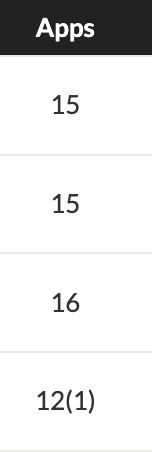

`Apps`는 출전 수인데, 12(1) 을 13으로 표현해준다.

### Apps 컬럼이 null 인 데이터 제거

In [653]:
attack_df = attack_df[~attack_df['Apps'].isna()]
midfield_df = midfield_df[~midfield_df['Apps'].isna()]
defender_df = defender_df[~defender_df['Apps'].isna()]

### apps 컬럼의 문자열을 실수형으로 변환

In [649]:
def convert_apps_to_number(apps_str):
    matches = re.findall(r'\d+', apps_str) # 하나 이상의 연속된 숫자를 찾음
    total_apps = sum(int(match) for match in matches)
    return total_apps

convert_apps_to_number('12(1)')
    

13

In [654]:
attack_df['Apps'] = attack_df['Apps'].apply(convert_apps_to_number).astype(float)
midfield_df['Apps'] = midfield_df['Apps'].apply(convert_apps_to_number).astype(float)
defender_df['Apps'] = defender_df['Apps'].apply(convert_apps_to_number).astype(float)

### 나머지 stats 컬럼의 데이터형도 실수형으로 변환

#### '-' 값을 0으로 교체

In [658]:
attack_stat_columns = attack_df.columns[11:]
midfield_stat_columns = midfield_df.columns[11:]
defender_stat_columns = defender_df.columns[11:]

print(attack_stat_columns)
print(midfield_stat_columns)
print(defender_stat_columns)

Index(['Apps', 'Mins', 'Tackles', 'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb',
       'Blocks', 'OwnG', 'Rating', 'Goals', 'Assists', 'SpG', 'KeyP', 'Fouled',
       'Off', 'Disp', 'UnsTch'],
      dtype='object')
Index(['Apps', 'Mins', 'Tackles', 'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb',
       'Blocks', 'OwnG', 'Rating', 'Assists', 'KeyP', 'AvgP', 'PS%', 'Crosses',
       'LongB', 'ThrB'],
      dtype='object')
Index(['Apps', 'Mins', 'Tackles', 'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb',
       'Blocks', 'OwnG', 'Rating'],
      dtype='object')


In [659]:
def convert_dash_to_zero(value):
    return 0 if value == '-' else value

attack_df[attack_stat_columns] = attack_df[attack_stat_columns].applymap(convert_dash_to_zero)
midfield_df[midfield_stat_columns] = midfield_df[midfield_stat_columns].applymap(convert_dash_to_zero)
defender_df[defender_stat_columns] = defender_df[defender_stat_columns].applymap(convert_dash_to_zero)

In [660]:
attack_df[attack_stat_columns] = attack_df[attack_stat_columns].astype(float)
midfield_df[midfield_stat_columns] = midfield_df[midfield_stat_columns].astype(float)
defender_df[defender_stat_columns] = defender_df[defender_stat_columns].astype(float)

### 컬럼 정리

In [663]:
columns = ['name', 'position', 'sub_position', 'age', 'market_value_in_eur']

attack_stats = attack_df[columns + list(attack_df.columns[11:])]
midfield_stats = midfield_df[columns + list(midfield_df.columns[11:])]
defender_stats = defender_df[columns + list(defender_df.columns[11:])]


## 몸값과 stat의 상관성

### 추세선과 산점도 시각화 - regplot

In [664]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_scatter_with_trendline(df, position_name, stat_columns):
    num_stats = len(stat_columns)
    rows = (num_stats - 1) // 3 + 1
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

    for i, stat in enumerate(stat_columns):
        row_index = i // 3
        col_index = i % 3
        ax = axes[row_index, col_index]

        sns.regplot(x=stat, y='market_value_in_eur', data=df, ax=ax, scatter_kws={'alpha': 0.7}, line_kws={'color': 'red'})
        ax.set_title(f"{position_name} Position - Market Value vs. {stat}")
        ax.set_xlabel(stat)
        ax.set_ylabel("Market Value (in EUR)")

    for i in range(num_stats, rows * 3):
        row_index = i // 3
        col_index = i % 3
        fig.delaxes(axes[row_index, col_index])

    plt.tight_layout()
    plt.show()


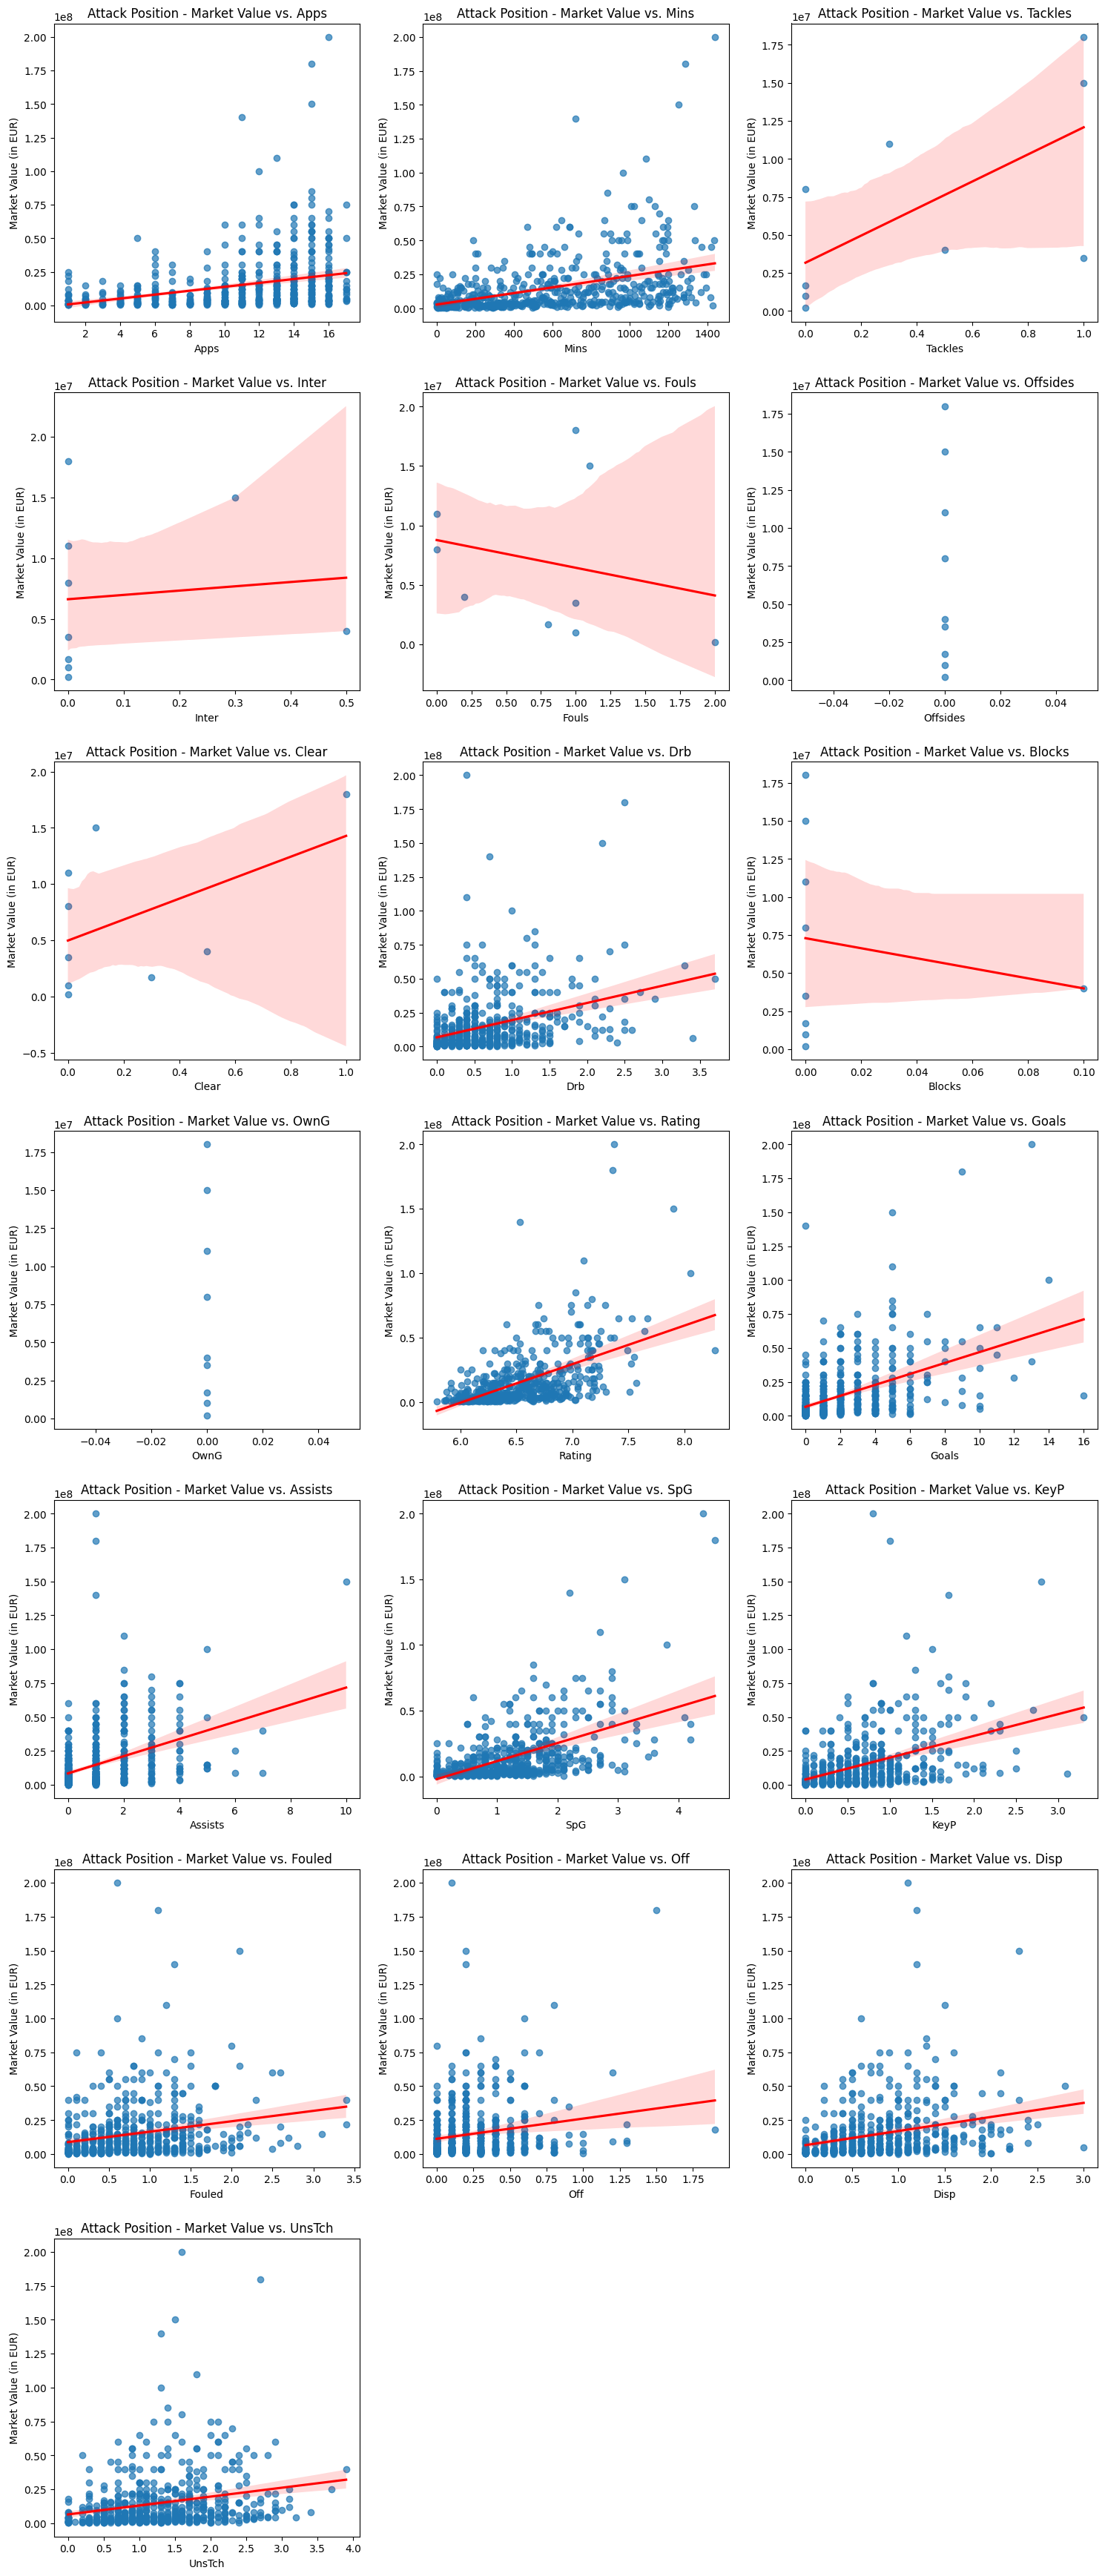

In [665]:
plot_scatter_with_trendline(attack_stats, 'Attack', attack_stat_columns)

### 상관계수 계산

In [668]:
attack_corr = attack_stats.corr(numeric_only=True)
midfield_corr = midfield_stats.corr(numeric_only=True)
defender_corr = defender_stats.corr(numeric_only=True)

### 상관계수 시각화 - heatmap

In [669]:
def plot_corr_heatmap(position_name, corr_df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(f'{position_name} Position - Correlation Heatmap')
    plt.show()

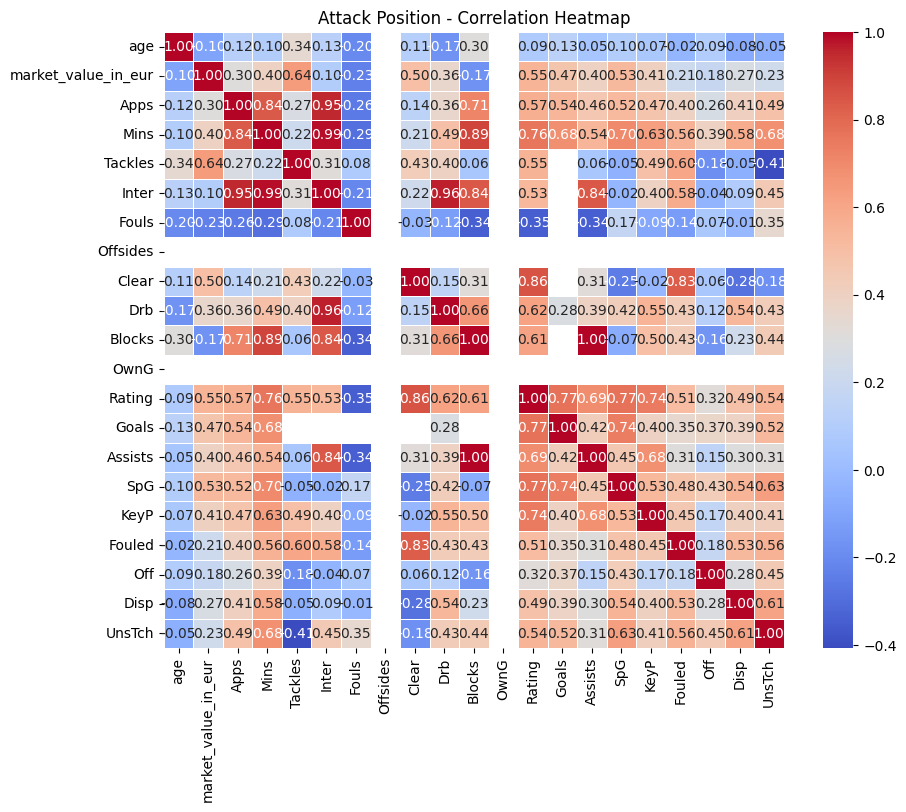

In [670]:
plot_corr_heatmap('Attack', attack_corr)